In [1]:
import os
import glob
import itertools
import json
import importlib

import pingouin as pg
import matplotlib as mpl
import scipy.stats as spstats
import dill as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl

import analyze2p.utils as hutils
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.plotting as pplot
import analyze2p.extraction.rois as rutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.objects.selectivity as sel

import analyze2p.decoding as dec

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Aggregate

In [2]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(tick_labelsize=6, lw_axes=0.25)

In [3]:
# SET PATHS
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir = '/n/coxfs01/2p-data'
migr_prefix = '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01'
aggregate_dir = aggregate_dir.replace('/n/coxfs01', migr_prefix)
rootdir = rootdir.replace('/n/coxfs01', migr_prefix)
# --

In [4]:
sdata, cells0, missing_ = aggr.get_aggregate_info(visual_areas=visual_areas, 
                                create_new=False,
                                return_cells=True, return_missing=True,
                                rootdir=rootdir,
                                aggregate_dir=aggregate_dir)

all_cell_counts = cells0[['visual_area', 'datakey', 'cell']]\
                    .drop_duplicates().groupby(['visual_area']).count().reset_index()

print(all_cell_counts.groupby(['visual_area']).sum())

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
             datakey  cell
visual_area               
Li              3305  3305
Lm              3914  3914
V1              3999  3999


In [5]:
# sdata, cells0, missing_ = aggr.get_aggregate_info(visual_areas=visual_areas, 
#                                                   create_new=False,
#                                                   return_cells=True, return_missing=True)
# all_cell_counts = cells0[['visual_area', 'datakey', 'cell']]\
#                     .drop_duplicates().groupby(['visual_area']).count().reset_index()

# print(all_cell_counts.groupby(['visual_area']).sum())

In [6]:
importlib.reload(aggr)

<module 'analyze2p.aggregate_datasets' from '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py'>

In [5]:
experiment='blobs'
trial_epoch = 'stimulus'
responsive_test='ROC'
# ---------------------------------------
responsive_thr=0.05 if responsive_test=='ROC' else 10.
response_type='dff'
traceid = 'traces001'

assigned_cells, meta = aggr.select_assigned_cells(cells0, sdata, 
                                        experiments=[experiment])
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                                       response_type=response_type,
                                       trial_epoch=trial_epoch,
                                       responsive_test=responsive_test,
                                       responsive_thr=responsive_thr)

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_stimulus.pkl
Checking mislabeled


# Output plotting

In [6]:
#aggregate_dir= '/n/coxfs01/julianarhee/aggregate-visual-areas'
aggregate_dir = aggregate_dir.replace('/n/coxfs01', migr_prefix)

FIGDIR = os.path.join(aggregate_dir, 'FIGURES')
bw_area_colors={'V1': [0.7]*3, 'Lm': [0.7]*3, 'Li': [0.7]*3}
# fontsize=6
# lw=0.25

dst_dir = os.path.join(aggregate_dir, 'blobs-tuning', \
                       'selectivity_tolerance', 'final')
print(dst_dir)
if not os.path.exists(os.path.join(dst_dir,'examples')):
    os.makedirs(os.path.join(dst_dir, 'examples'))
data_id = '%s|%s_%s-%.2f' % (traceid, response_type, responsive_test, responsive_thr)
print(data_id)


/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final
traces001|dff_ROC-0.05


In [7]:
# exclude =[] # ['20190627_JC091_fov1', '20191111_JC120_fov1', '20190506_JC080_fov1']

# NDATA0 = NDATA_[~(NDATA_.datakey.isin(exclude))].copy()



In [68]:
filter_rfs=True
if filter_rfs:
    cells_overlap = dec.get_cells_with_overlap(assigned_cells, sdata, 
                                 greater_than=False,
                                overlap_thr=0.1)
    NDATA0_rf = aggr.get_neuraldata_for_included_cells(cells_overlap, NDATA0)
    curr_counts = NDATA0_rf[['visual_area', 'datakey', 'cell']].drop_duplicates()
else:
    curr_counts = NDATA0[['visual_area', 'datakey', 'cell']].drop_duplicates()

n_cells_all = aggr.count_n_cells(curr_counts, name='cell')

N dpaths: 56, N unfit: 0
N datasets included: 61, N sessions excluded: 4


/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/receptive_fields/utils.py:1261: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  meanrf = curr_rfdf.groupby(['cell']).mean().reset_index()
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/receptive_fields/utils.py:1275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  metainfo = pd.concat([g[non_num].iloc[0] for c, g in \
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/receptive_fields/utils.py:1261: FutureWarning: The default valu

    adding 20190430_JC078_fov1, 38
    adding 20190501_JC076_fov1, 9
    adding 20190504_JC078_fov1, 12
    adding 20190506_JC080_fov1, 40
    adding 20190507_JC083_fov1, 58
    adding 20190508_JC083_fov1, 79
    adding 20190509_JC078_fov1, 5
    adding 20190510_JC083_fov1, 33
    adding 20190511_JC083_fov1, 47
    adding 20190512_JC083_fov1, 59
    adding 20190513_JC078_fov1, 23
    adding 20190517_JC083_fov1, 23
    adding 20190522_JC084_fov1, 134
    adding 20190525_JC084_fov1, 42
    adding 20190602_JC091_fov1, 90
    adding 20190603_JC080_fov1, 59
    adding 20190606_JC091_fov1, 38
    adding 20190607_JC091_fov1, 70
    adding 20190609_JC099_fov1, 47
    adding 20190612_JC099_fov1, 54
    adding 20190613_JC097_fov1, 118
    adding 20190614_JC091_fov1, 92
    adding 20190616_JC097_fov1, 152
    adding 20190617_JC097_fov1, 89
    adding 20190617_JC099_fov1, 16
    adding 20190618_JC097_fov1, 32
    adding 20190622_JC085_fov1, 106
    adding 20190627_JC091_fov1, 7
    adding 20191006

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/sim_utils.py:569: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  stim_polys = pkl.load(f)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/L

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/sim_utils.py:569: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  stim_polys = pkl.load(f)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/L

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/sim_utils.py:569: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  stim_polys = pkl.load(f)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/L

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/sim_utils.py:569: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  stim_polys = pkl.load(f)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/L

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/sim_utils.py:569: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  stim_polys = pkl.load(f)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/L

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/sim_utils.py:569: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  stim_polys = pkl.load(f)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/L

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/sim_utils.py:569: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  stim_polys = pkl.load(f)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/L

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/sim_utils.py:569: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  stim_polys = pkl.load(f)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/L

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/sim_utils.py:569: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  stim_polys = pkl.load(f)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/L

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/sim_utils.py:569: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  stim_polys = pkl.load(f)
/n/holylfs05/LABS/pfister_lab/L

In [70]:
NDATA0_rf[['visual_area', 'datakey', 'cell']].drop_duplicates()\
    .groupby('visual_area').count()

,datakey,cell
visual_area,,
Li,153,153
Lm,146,146
V1,532,532


In [8]:
NDATA0_rf[['visual_area', 'datakey', 'cell']].drop_duplicates()\
    .groupby('visual_area').count()

,datakey,cell
visual_area,,
Li,202,202
Lm,271,271
V1,612,612


In [71]:
curr_counts = NDATA0_rf[['visual_area', 'datakey', 'cell']].drop_duplicates()
curr_counts

,visual_area,datakey,cell
1499,Li,20190602_JC091_fov1,15
2998,Li,20190602_JC091_fov1,16
7495,Li,20190602_JC091_fov1,23
8994,Li,20190602_JC091_fov1,26
10493,Li,20190602_JC091_fov1,27
...,...,...,...
120600,V1,20191006_JC110_fov1,310
123950,V1,20191006_JC110_fov1,336
127300,V1,20191006_JC110_fov1,338
134000,V1,20191006_JC110_fov1,356


In [72]:
n_cells_all = aggr.count_n_cells(curr_counts, name='cell')
n_cells_all

,visual_area,datakey,cell
0,Li,20190602_JC091_fov1,53
1,Li,20190606_JC091_fov1,6
2,Li,20190607_JC091_fov1,17
3,Li,20190609_JC099_fov1,23
4,Li,20190612_JC099_fov1,13
5,Li,20190614_JC091_fov1,32
6,Li,20191018_JC113_fov1,8
7,Li,20191111_JC120_fov1,1
8,Lm,20190430_JC078_fov1,12
9,Lm,20190504_JC078_fov1,3


In [8]:
# # # Get unique dkeys and count
# u_dkeys = aggr.drop_repeats(n_cells_all)
# min_ncells=20
# if filter_rfs:
#     NDATA_all = pd.concat([g for (va, dk), g in NDATA0_rf.groupby(['visual_area', 'datakey'])\
#                    if (va, dk) in u_dkeys and len(g['cell'].unique())>=min_ncells])
# else:
#     NDATA_all = pd.concat([g for (va, dk), g in NDATA0.groupby(['visual_area', 'datakey'])\
#                    if (va, dk) in u_dkeys and len(g['cell'].unique())>=min_ncells])

In [18]:
importlib.reload(aggr)

<module 'analyze2p.aggregate_datasets' from '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py'>

In [73]:
SDF, incorrect_stims = aggr.check_sdfs(n_cells_all['datakey'].unique(),
                      experiment='blobs', rename=True, images_only=False,
                      return_incorrect=True, return_all=False)
print(incorrect_stims.keys())

dict_keys([])


In [74]:
min_ncells=5
enough_cells = [(k, v) for k, v in n_cells_all[n_cells_all['cell']>min_ncells]\
                [['visual_area', 'datakey']].drop_duplicates().values]
correct_stims = SDF['datakey'].unique()
# -----------------------------------
# NDATA_ = pd.concat([g for (va, dk), g in NDATA0.groupby(['visual_area', 'datakey'])\
#                        if (va, dk) in enough_cells and dk in correct_stims])
NDATA_ = pd.concat([g for (va, dk), g in NDATA0_rf.groupby(['visual_area', 'datakey'])\
                       if (va, dk) in enough_cells and dk in correct_stims])

In [75]:
'20190322_JC073_fov1' in NDATA_['datakey'].unique()

False

In [76]:
NDATA_im = None
i_=[]
for (va, dk), ndf in NDATA_.groupby(['visual_area', 'datakey']):
    sdf = aggr.get_stimuli(dk, experiment='blobs', match_names=True)
    im_df = sel.exclude_lum_is_best(ndf, sdf)
    i_.append(im_df)
NDATA_im = pd.concat(i_, axis=0, ignore_index=True)

## Count fraction lum-preferring

In [77]:
importlib.reload(sel)

<module 'analyze2p.objects.selectivity' from '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py'>

In [78]:
totals, cnt_each = sel.count_fraction_luminance_preferring(NDATA_, NDATA_im)

<IPython.core.display.Javascript object>


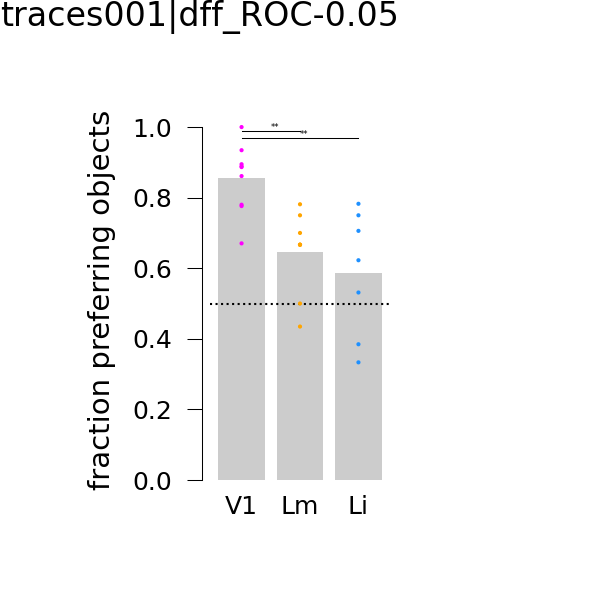

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py:880: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='visual_area', y=metric, data=plotdf, ax=ax,
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


In [79]:
%matplotlib notebook
metric = 'pref_object'
fig, ax = pl.subplots(figsize=(2,2), dpi=150)
pplot.stripplot_metric_by_area(cnt_each, metric, area_colors=area_colors,ax=ax,
                            markersize=2, ylim=(0,1.02), 
                            sig_fontsize=2, jitter=False, 
                            plot_means=True, y_loc=0.95, offset=0.02,
                            mean_style='bar', mean_type='mean', aspect=2)
ax.axhline(y=0.5, lw=0.5, ls=':', color='k')
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')
ax.set_ylabel('fraction preferring objects')
sns.despine(bottom=True, trim=True)

pplot.label_figure(fig, data_id)
figname = 'fraction_%s' % metric
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

<IPython.core.display.Javascript object>


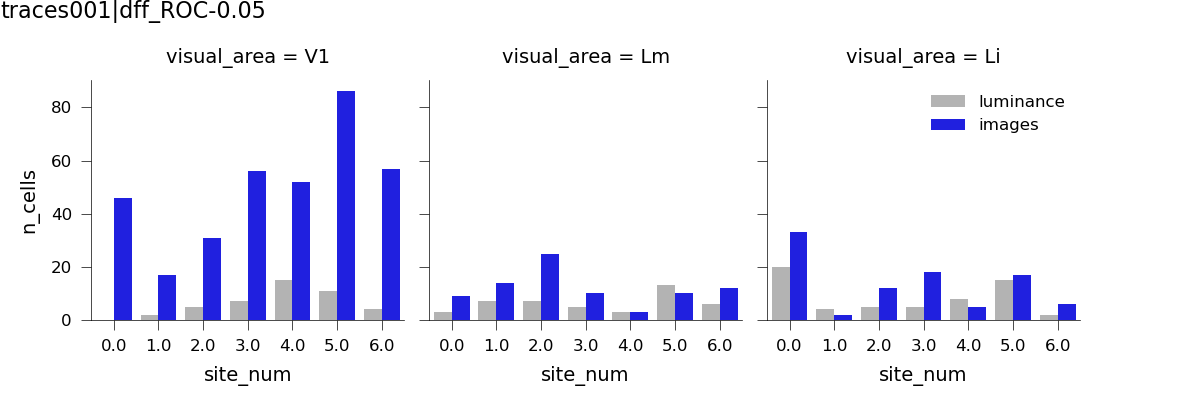

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/axisgrid.py:717: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


In [80]:
%matplotlib notebook
fg = sns.FacetGrid(col='visual_area', height=2, col_order=visual_areas,
            data=totals[totals.stimuli.isin(['luminance', 'images'])])
fg.map(sns.barplot, 'site_num', 'n_cells', 'stimuli', 
       palette={'luminance': [0.7]*3, 'images': 'blue'})
totals.groupby('visual_area').min()
fg.fig.axes[-1].legend(frameon=False)
pl.subplots_adjust(bottom=0.2, right=0.9, top=0.8)

pplot.label_figure(fg.fig, data_id)
figname = 'n_lum_preferring_hists'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

In [82]:
cnt_each

,visual_area,datakey,n_all,n_images,site_num,pref_object,n_luminance,pref_luminance
0,Li,20190602_JC091_fov1,53,33,0.0,0.622642,20,0.377358
1,Li,20190606_JC091_fov1,6,2,1.0,0.333333,4,0.666667
2,Li,20190607_JC091_fov1,17,12,2.0,0.705882,5,0.294118
3,Li,20190609_JC099_fov1,23,18,3.0,0.782609,5,0.217391
4,Li,20190612_JC099_fov1,13,5,4.0,0.384615,8,0.615385
5,Li,20190614_JC091_fov1,32,17,5.0,0.531250,15,0.468750
6,Li,20191018_JC113_fov1,8,6,6.0,0.750000,2,0.250000
7,Lm,20190430_JC078_fov1,12,9,0.0,0.750000,3,0.250000
8,Lm,20190506_JC080_fov1,21,14,1.0,0.666667,7,0.333333
9,Lm,20190508_JC083_fov1,32,25,2.0,0.781250,7,0.218750


In [83]:
exclude_by_fraction=False
min_pref_lum = 0.5 if exclude_by_fraction else 1.0
if exclude_by_fraction:
    pref_obj = [(k, v) for k, v in \
                cnt_each[cnt_each['pref_luminance']<min_pref_lum]\
                [['visual_area', 'datakey']].values]
    NDATA1 = pd.concat([g for (va, dk), g in NDATA_.groupby(['visual_area', 'datakey'])\
                           if (va, dk) in pref_obj])
else:
    NDATA1 = NDATA_.copy()

In [84]:
curr_counts = NDATA1[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count().reset_index()
n_cells_all = aggr.count_n_cells(curr_counts, name='cell')
u_dkeys = aggr.drop_repeats(n_cells_all)
NDATA_all = pd.concat([g for (va, dk), g in NDATA1.groupby(['visual_area', 'datakey'])\
                   if (va, dk) in u_dkeys and len(g['cell'].unique())>=min_ncells])

In [85]:
NDATA_im = None
i_=[]
for (va, dk), ndf in NDATA_all.groupby(['visual_area', 'datakey']):
    sdf = aggr.get_stimuli(dk, experiment='blobs', match_names=True)
    im_df = sel.exclude_lum_is_best(ndf, sdf)
    i_.append(im_df)
NDATA_im = pd.concat(i_, axis=0) #, ignore_index=True)

In [86]:
totals, cnt_each = sel.count_fraction_luminance_preferring(NDATA_all, NDATA_im)

<IPython.core.display.Javascript object>


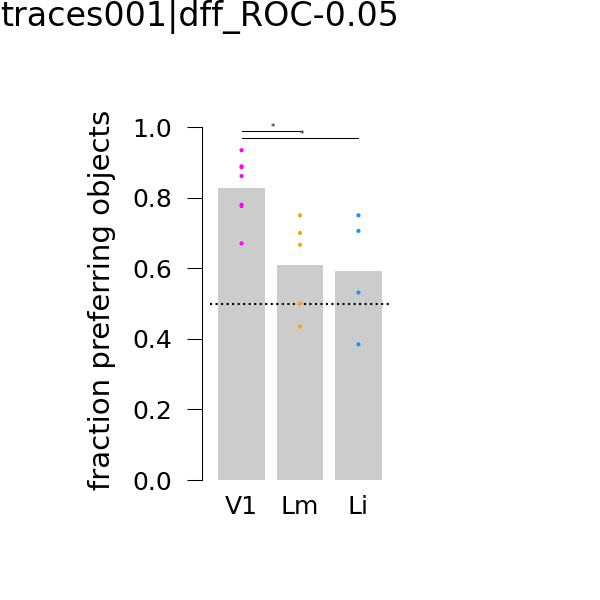

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py:880: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='visual_area', y=metric, data=plotdf, ax=ax,
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


In [87]:
%matplotlib notebook
metric = 'pref_object'
fig, ax = pl.subplots(figsize=(2,2), dpi=150)
pplot.stripplot_metric_by_area(cnt_each, metric, area_colors=area_colors,ax=ax,
                            markersize=2, ylim=(0,1.02), 
                            sig_fontsize=2, jitter=False, 
                            plot_means=True, y_loc=0.95, offset=0.02,
                            mean_style='bar', mean_type='mean', aspect=2)
ax.axhline(y=0.5, lw=0.5, ls=':', color='k')
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')
ax.set_ylabel('fraction preferring objects')
sns.despine(bottom=True, trim=True)

pplot.label_figure(fig, data_id)
figname = 'fraction_%s' % metric
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

<IPython.core.display.Javascript object>


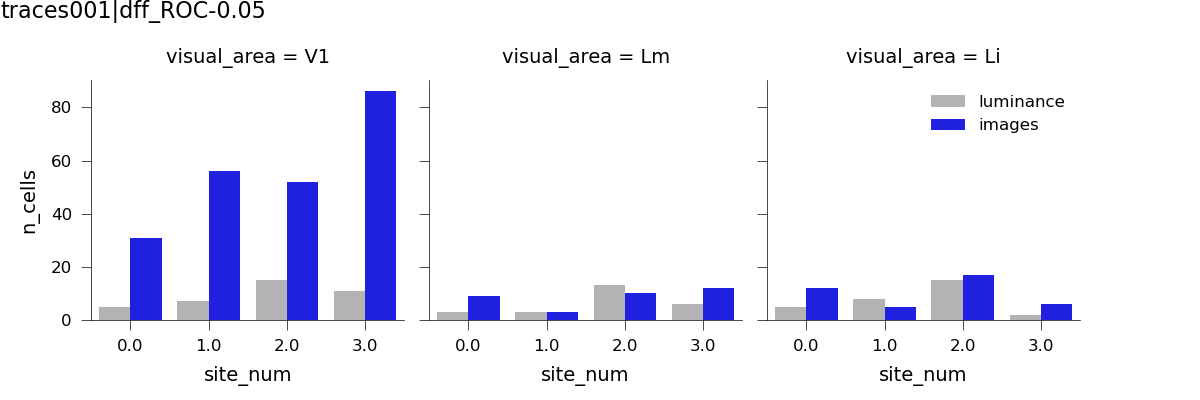

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/axisgrid.py:717: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


In [88]:
%matplotlib notebook
fg = sns.FacetGrid(col='visual_area', height=2, col_order=visual_areas,
            data=totals[totals.stimuli.isin(['luminance', 'images'])])
fg.map(sns.barplot, 'site_num', 'n_cells', 'stimuli', 
       palette={'luminance': [0.7]*3, 'images': 'blue'})
totals.groupby('visual_area').min()
fg.fig.axes[-1].legend(frameon=False)
pl.subplots_adjust(bottom=0.2, right=0.9, top=0.8)

pplot.label_figure(fg.fig, data_id)
figname = 'n_lum_preferring_hists'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

# Aggregate metrics

In [89]:
# SDF, mislabeled = aggr.check_sdfs(meta['datakey'].unique(), experiment=experiment,
#                      images_only=False, rename=True, return_incorrect=True,
#                      return_all=True)

In [90]:
importlib.reload(sel)

<module 'analyze2p.objects.selectivity' from '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py'>

In [91]:
exclude=[] # wrong configs
offset_type = 'minsub'
lcorrection = 'exclude'
filter_str = 'offset-%s_lum-%s' % (offset_type, lcorrection)
print(filter_str)

NDATA = NDATA_all.copy() #0.copy() # NDATA_all.copy() #if normalize_luminance else NDATA_im.copy()
# ----------------------------------------------------------------
ixdf = sel.aggregate_cell_metrics(NDATA, offset_type=offset_type, 
                                 lcorrection=lcorrection)
print(ixdf['n_cells'].min())

offset-minsub_lum-exclude


/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py:532: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rdf0 = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py:532: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rdf0 = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/obje

6


/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py:532: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rdf0 = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py:532: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rdf0 = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)


In [92]:
mean_per_cell = NDATA.groupby(['visual_area', 'datakey', 'cell', 'config']).mean()\
                    .reset_index()
len(mean_per_cell['config'].unique())

50

In [93]:
sdf_master = aggr.get_master_sdf(experiment='blobs', images_only=False)
mean_per_cell['size'] = [sdf_master.loc[cfg]['size'] \
                             for cfg in mean_per_cell['config'].values]
mean_per_cell['morphlevel'] = [sdf_master.loc[cfg]['morphlevel'] \
                             for cfg in mean_per_cell['config'].values]


In [94]:
mean_per_fov = mean_per_cell.groupby(['visual_area', 'datakey', 'config', 'size', 'morphlevel'])\
                .median().reset_index()
mean_per_fov

,visual_area,datakey,config,size,morphlevel,cell,trial,response
0,Li,20190607_JC091_fov1,config001,10.0,-1,179.0,745.000000,0.062958
1,Li,20190607_JC091_fov1,config002,20.0,-1,179.0,748.633333,0.040063
2,Li,20190607_JC091_fov1,config003,30.0,-1,179.0,750.700000,0.040159
3,Li,20190607_JC091_fov1,config004,40.0,-1,179.0,750.500000,0.025797
4,Li,20190607_JC091_fov1,config005,50.0,-1,179.0,749.233333,0.053464
...,...,...,...,...,...,...,...,...
795,V1,20191006_JC110_fov1,config046,10.0,106,168.5,833.823529,0.075597
796,V1,20191006_JC110_fov1,config047,20.0,106,168.5,835.970588,0.084247
797,V1,20191006_JC110_fov1,config048,30.0,106,168.5,836.470588,0.045888
798,V1,20191006_JC110_fov1,config049,40.0,106,168.5,837.588235,0.035673


<IPython.core.display.Javascript object>


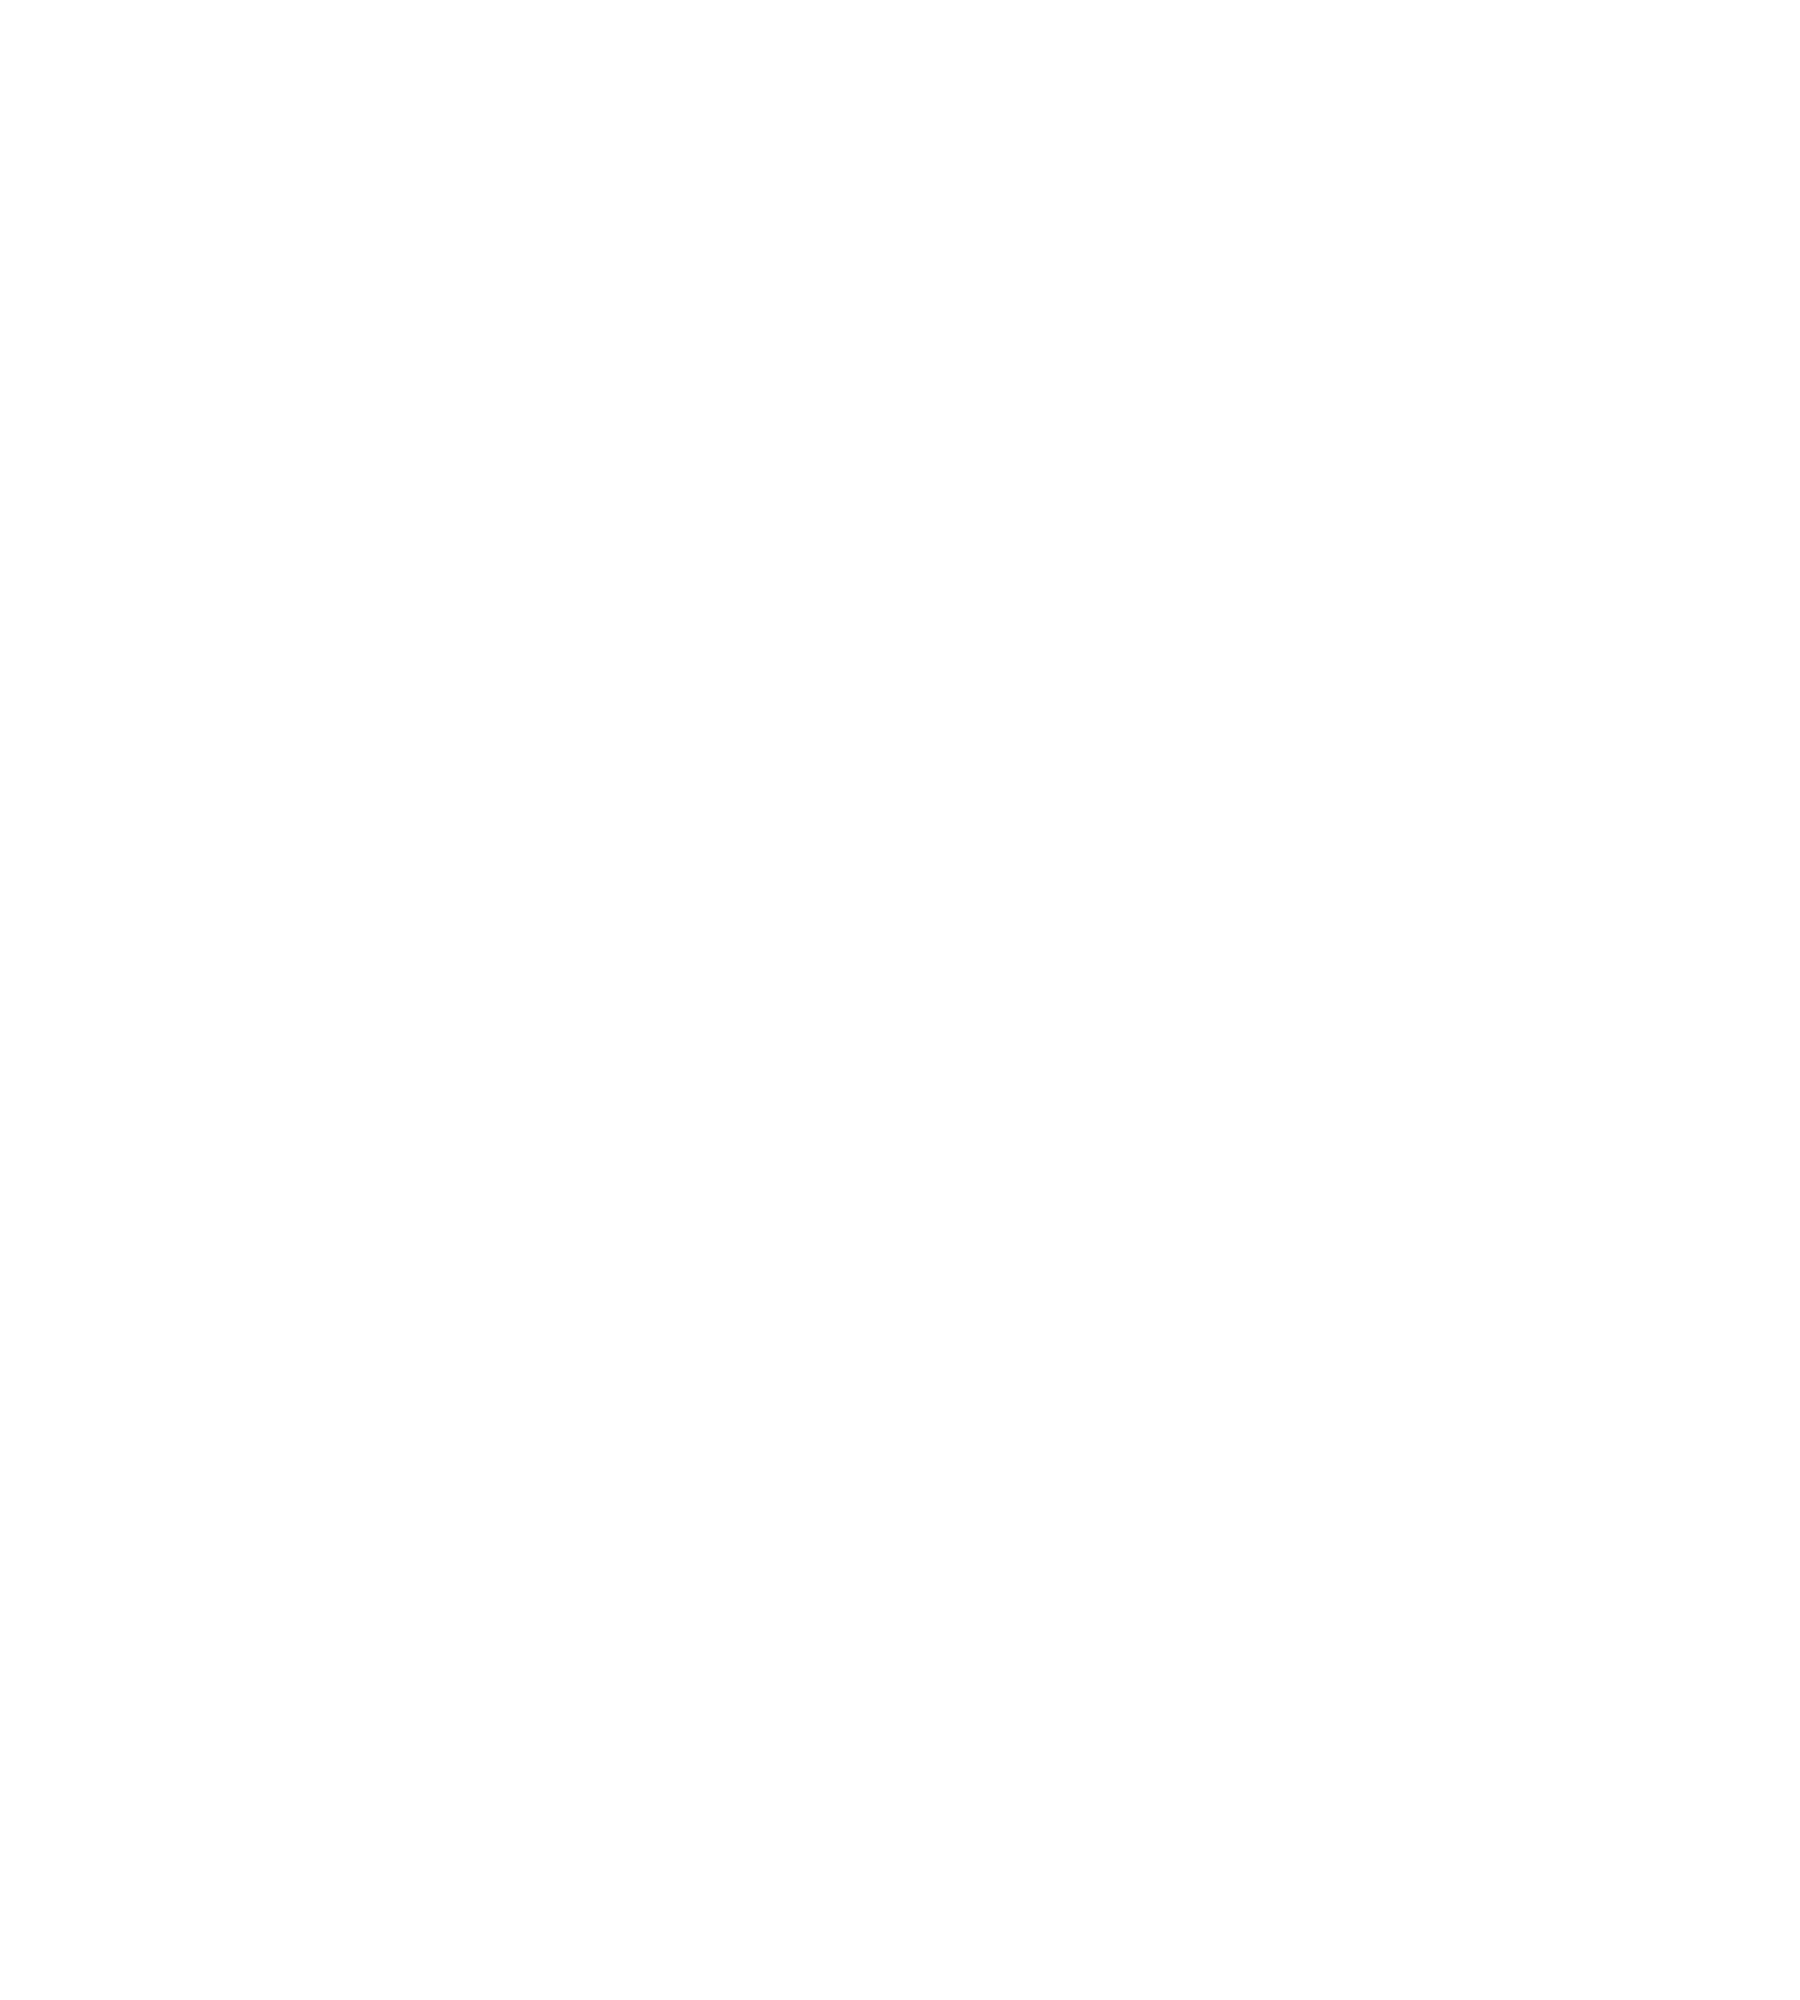

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/n/h

In [95]:
morph_resp_fov = mean_per_fov[mean_per_fov.morphlevel!=-1].copy()
fg = sns.FacetGrid(data=morph_resp_fov, col='morphlevel', row='size', aspect=.5,
                   height=2)
fg.map(sns.barplot, 'visual_area', 'response',
      order=visual_areas, ci=None, color=[0.8]*3)
fg.map(sns.stripplot, 'visual_area', 'response', 'visual_area',
      order=visual_areas, palette=area_colors, size=3, jitter=False,
       hue_order=visual_areas)
fg.set_titles("sz={row_name}\nmp={col_name}")
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.9)
fg.fig.text(0.01, 0.92, filter_str)

pplot.label_figure(fig, data_id)
figname ='avg_response_per_cond_%s' % filter_str
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))


<IPython.core.display.Javascript object>


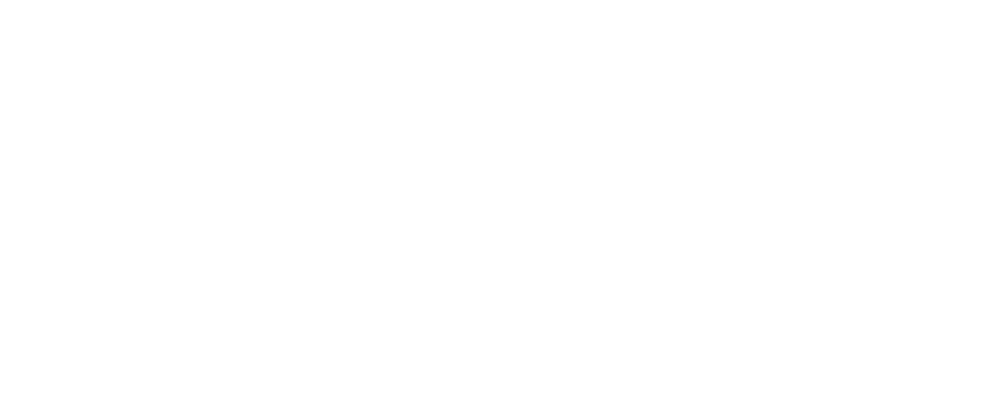

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/n/h

In [105]:
morph_resp_fov = mean_per_fov[mean_per_fov.morphlevel==-1].copy()
fg = sns.FacetGrid(data=morph_resp_fov, col='size', row='morphlevel', aspect=.5,
                   height=2)
fg.map(sns.barplot, 'visual_area', 'response',
      order=visual_areas, ci=None, color=[0.8]*3)
fg.map(sns.stripplot, 'visual_area', 'response', 'visual_area',
      order=visual_areas, palette=area_colors, size=3, jitter=False,
       hue_order=visual_areas)
fg.set_titles("sz={row_name}\nmp={col_name}")

pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.9)
fg.fig.text(0.01, 0.92, filter_str)


figname ='avg_response_per_cond_LUM_%s' % filter_str
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

In [108]:
dst_dir

'/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final'

In [109]:
min_ncells=5
print(ixdf.shape)
lum_cols = [k for k in ixdf.columns if 'lum' in k]
if lcorrection=='normalize':
    for k in lum_cols:
        ixdf = ixdf.drop(k, 1)
for va, vg in ixdf.groupby('visual_area'):
    dk_lut = dict((v, i) for i, v in enumerate(vg['datakey'].unique()))
    ixdf.loc[vg.index, 'site_num'] = [dk_lut[k] for k in vg['datakey'].values]
DF = ixdf[ixdf['n_cells']>=min_ncells].copy().dropna()
print(ixdf.shape, ixdf.dropna().shape, DF.shape)

(461, 16)
(461, 16) (461, 16) (461, 16)


In [110]:
print('size_tol', ixdf[(ixdf['size_tol']>1) | (ixdf['size_tol']<0)].shape)
print('morph_sel', ixdf[(ixdf['morph_sel']>1) | (ixdf['morph_sel']<0)].shape)
print('sparseness_morphs', ixdf[(ixdf['sparseness_morphs']>1) | (ixdf['sparseness_morphs']<0)].shape)

size_tol (0, 16)
morph_sel (0, 16)
sparseness_morphs (0, 16)


In [111]:
# Get means by FOV
means_by_fov = DF.groupby(['visual_area', 'datakey']).median().reset_index()
ncells_by_fov = DF.groupby(['visual_area', 'datakey']).count().reset_index()[['visual_area', 'datakey', 'cell']]\
                    .rename(columns={'cell': 'n_cells'})
fovdf = pd.merge(means_by_fov, ncells_by_fov, on=['visual_area', 'datakey'])

In [112]:
fovdf

,visual_area,datakey,morph_sel,best_size,size_tol,best_morphlevel,sparseness_total,sparseness_morphs,sparseness_anchors,size_sel,lum_sel,lum_size_cc,lum_size_pval,cell,n_cells_x,site_num,n_cells_y
0,Li,20190607_JC091_fov1,0.329323,10.0,0.431664,79.0,0.171314,0.165524,0.103397,0.568336,0.387394,0.224660,0.461207,202.5,17.0,0.0,12
1,Li,20190612_JC099_fov1,0.473089,10.0,0.493157,92.0,0.130164,0.128270,0.102464,0.506843,0.413197,-0.173646,0.300298,108.0,13.0,1.0,5
2,Li,20190614_JC091_fov1,0.349096,10.0,0.449518,66.0,0.181506,0.168593,0.139537,0.550482,0.644034,0.573451,0.312128,251.0,32.0,2.0,17
3,Li,20191018_JC113_fov1,0.364117,15.0,0.557943,46.5,0.127617,0.110046,0.099524,0.442057,0.555705,-0.055625,0.210124,112.5,8.0,3.0,6
4,Lm,20190430_JC078_fov1,0.287600,20.0,0.397616,79.0,0.207751,0.177551,0.162246,0.602384,0.640978,0.199257,0.267064,135.0,12.0,0.0,9
5,Lm,20190517_JC083_fov1,0.523432,30.0,0.378651,27.0,0.265143,0.198230,0.276836,0.621349,0.736551,-0.500266,0.390709,45.0,6.0,1.0,3
6,Lm,20190525_JC084_fov1,0.269577,10.0,0.413906,72.5,0.277332,0.224440,0.141064,0.586094,0.743114,0.799857,0.112069,110.0,23.0,2.0,10
7,Lm,20190603_JC080_fov1,0.375805,10.0,0.302162,106.0,0.349621,0.362394,0.388961,0.697838,0.564992,0.379621,0.255141,87.0,18.0,3.0,12
8,Lm,20190618_JC097_fov1,0.391223,30.0,0.503233,27.0,0.217367,0.194470,0.221695,0.496767,0.664909,-0.107173,0.524877,72.0,10.0,4.0,7
9,V1,20190511_JC083_fov1,0.329780,20.0,0.439622,53.0,0.208289,0.186139,0.186320,0.560378,0.512295,0.063442,0.586709,76.0,36.0,0.0,31


## By fov metrics

[median]:
  visual_area  sparseness_morphs  morph_sel  size_tol   lum_sel  lum_size_cc  \
0          Li           0.146897   0.356606  0.471337  0.484451     0.084517   
1          Lm           0.198230   0.375805  0.397616  0.664909     0.199257   
2          V1           0.191881   0.329780  0.469502  0.512295     0.366714   

   sparseness_total  sparseness_morphs_std  morph_sel_std  size_tol_std  \
0          0.150739               0.028666       0.064385      0.056202   
1          0.265143               0.075120       0.101118      0.072250   
2          0.208289               0.021777       0.024391      0.028641   

   lum_sel_std  lum_size_cc_std  sparseness_total_std  
0     0.121194         0.332501              0.027769  
1     0.073603         0.491518              0.056673  
2     0.039963         0.204918              0.019958  


<IPython.core.display.Javascript object>


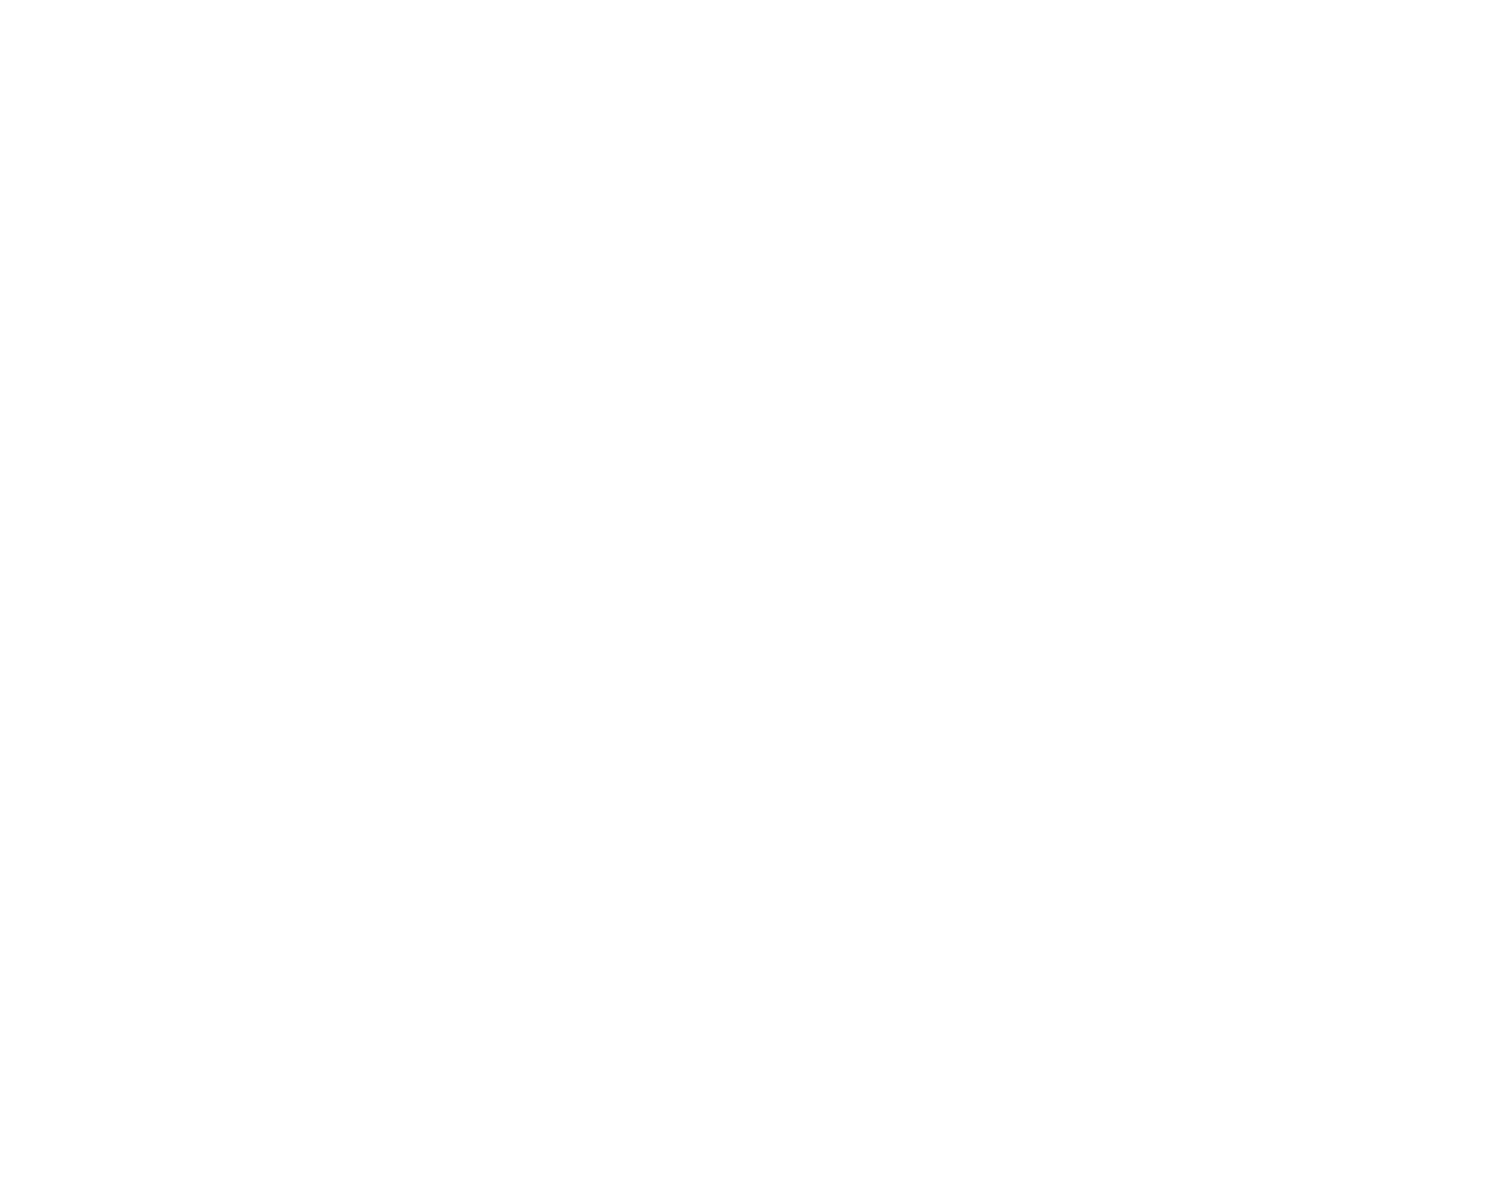

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final metrics_byFOV_offset-minsub_lum-exclude
sparseness_morphs ------------------------
             count  mean   std   min   25%   50%   75%   max
visual_area                                                 
Li             4.0  0.14  0.03  0.11  0.12  0.15  0.17  0.17
Lm             5.0  0.23  0.08  0.18  0.19  0.20  0.22  0.36
V1             7.0  0.20  0.02  0.17  0.18  0.19  0.21  0.23
morph_sel ------------------------
             count  mean   std   min   25%   50%   75%   max
visual_area                                                 
Li             4.0  0.38  0.06  0.33  0.34  0.36  0.39  0.47
Lm             5.0  0.37  0.10  0.27  0.29  0.38  0.39  0.52
V1             7.0  0.34  0.02  0.31  0.33  0.33  0.34  0.39
size_tol ------------------------
             count  mean   std   min   25%   50%   75%   max
visual_area                                                

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py:880: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='visual_area', y=metric, data=plotdf, ax=ax,
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py:880: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='visual_area', y=metric, data=plotdf, ax=ax,
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pai

In [113]:
%matplotlib notebook
plot_params=['sparseness_morphs', 'morph_sel', 'size_tol', 
             'lum_sel', 'lum_size_cc', 'sparseness_total', ]

mean_type='median'
multi_comp_test='fdr_by' #'fdr_bh'
markersize = 3
fw=5
ymax=0.8 + 0.04
plotdf = fovdf.copy()
# ----------------------------------------------------------
pplot.print_means(plotdf, groupby=['visual_area'], params=plot_params,
                  metric=mean_type)
fig, axn = pl.subplots(2, int(len(plot_params)/2), figsize=(fw, 4), 
                       sharex=True, sharey=False, dpi=150)
for ai, metric in enumerate(plot_params):
    ax=axn.flat[ai]
    ymax = np.ceil(plotdf[metric].max())*1.1
    y_loc = np.ceil(plotdf[metric].max())*0.85
    ylim = (-ymax,ymax) if metric=='lum_size_cc' else (0, ymax)
    pplot.stripplot_metric_by_area(plotdf, metric, area_colors=area_colors,
                                markersize=markersize, ylim=ylim, ax=ax,
                                sig_fontsize=4, jitter=False, 
                                plot_means=True, y_loc=y_loc, offset=y_loc/15.,
                                mean_style='bar', mean_type=mean_type, aspect=2)
pl.subplots_adjust(bottom=0.2, left=0.1, right=0.9, top=0.8, wspace=0.6)
sns.despine(offset=8, trim=True, bottom=True)
fig.text(0.0, 0.9, filter_str, fontsize=6)

pplot.label_figure(fig, data_id)
figname = 'metrics_byFOV_%s' % filter_str
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

for par in plot_params:
    print("%s ------------------------" % par)
    print(plotdf.groupby('visual_area')[par].describe().round(2))


In [115]:
importlib.reload(pplot)

<module 'analyze2p.plotting' from '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py'>

[median]:
  visual_area  sparseness_morphs  morph_sel  size_tol   lum_sel  lum_size_cc  \
0          Li           0.155737   0.345047  0.493415  0.555705     0.309851   
1          Lm           0.206837   0.344341  0.369583  0.647655     0.369472   
2          V1           0.191617   0.331567  0.471213  0.524761     0.302007   

   sparseness_total  sparseness_morphs_std  morph_sel_std  size_tol_std  \
0          0.168933               0.096989       0.109082      0.139051   
1          0.254094               0.114063       0.152962      0.146420   
2          0.206537               0.095544       0.152102      0.155343   

   lum_sel_std  lum_size_cc_std  sparseness_total_std  
0     0.196382         0.572086              0.097982  
1     0.176374         0.617964              0.103846  
2     0.175684         0.566326              0.089453  


<IPython.core.display.Javascript object>


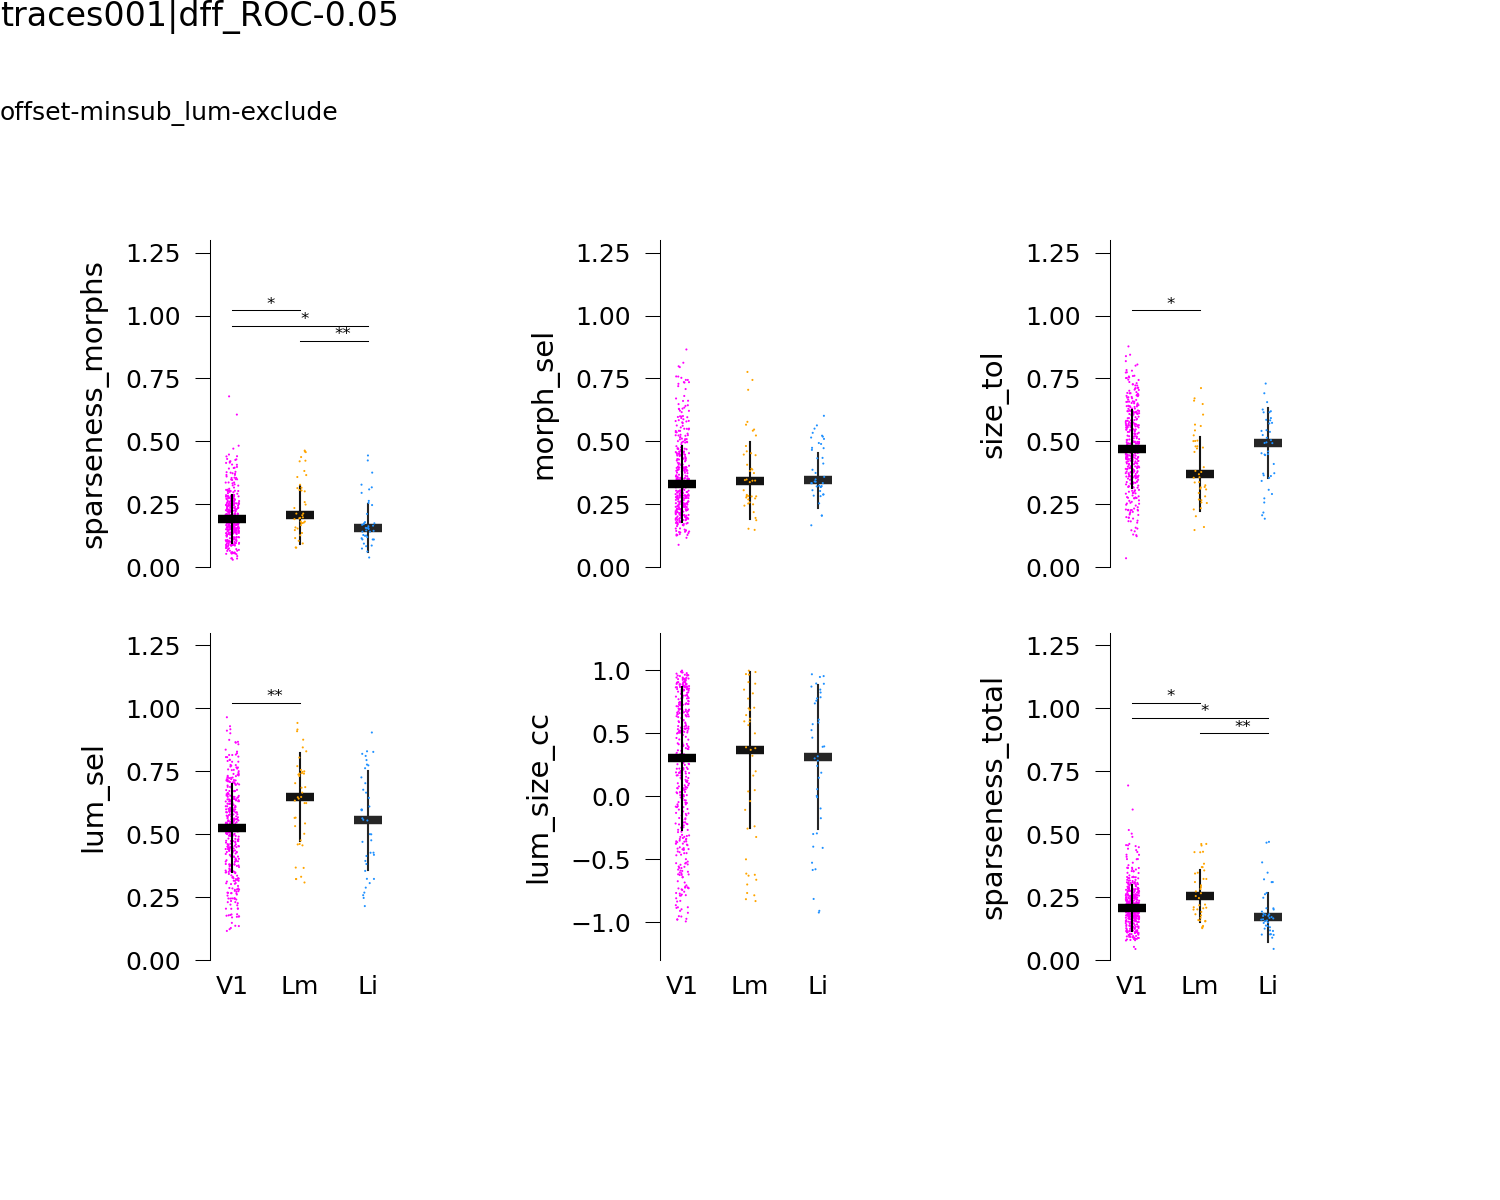

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py:875: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(x='visual_area', y=metric, data=plotdf, ax=ax,
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/li

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final metrics_byCELL_offset-minsub_lum-exclude_2


In [116]:
%matplotlib notebook
mean_type = 'median'
multi_comp_test='fdr_bh' #'fdr_bh'

fw=5
markersize = 1 

plotdf = DF.copy() #dropna().copy()
# ----------------------------------------------------------
pplot.print_means(plotdf, groupby=['visual_area'], params=plot_params,
              metric=mean_type)
fig, axn = pl.subplots(2, int(len(plot_params)/2), figsize=(fw, 4), 
                       sharex=True, sharey=False, dpi=150)
for ai, metric in enumerate(plot_params):
    ax=axn.flat[ai]
    ymax = np.ceil(plotdf[metric].max())*1.3
    y_loc = np.ceil(plotdf[metric].max())*0.9
    ylim = (-ymax,ymax) if metric=='lum_size_cc' else (0, ymax)
    pplot.stripplot_metric_by_area(plotdf, metric, area_colors=area_colors,
                                markersize=markersize, ylim=ylim, ax=ax,
                                sig_fontsize=4, jitter=True, aspect=2,
                                plot_means=True, y_loc=y_loc, offset=y_loc/15.,
                                mean_style='point', mean_type=mean_type)
    #ax.legend_.remove()
pl.subplots_adjust(bottom=0.2, left=0.1, right=0.9, top=0.8, wspace=0.5)
fig.text(0.0, 0.9, filter_str, fontsize=6)

pplot.label_figure(fig, data_id)
figname = 'metrics_byCELL_%s_2' % filter_str
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [117]:

for par in plot_params:
    print("%s ------------------------" % par)
    print(plotdf.groupby('visual_area')[par].describe().round(2))


sparseness_morphs ------------------------
             count  mean   std   min   25%   50%   75%   max
visual_area                                                 
Li            40.0  0.18  0.10  0.04  0.12  0.16  0.22  0.44
Lm            41.0  0.25  0.11  0.08  0.17  0.21  0.32  0.46
V1           380.0  0.21  0.10  0.03  0.14  0.19  0.26  0.68
morph_sel ------------------------
             count  mean   std   min   25%   50%   75%   max
visual_area                                                 
Li            40.0  0.38  0.11  0.17  0.32  0.35  0.48  0.60
Lm            41.0  0.38  0.15  0.15  0.27  0.34  0.45  0.78
V1           380.0  0.36  0.15  0.09  0.24  0.33  0.45  0.87
size_tol ------------------------
             count  mean   std   min   25%   50%   75%   max
visual_area                                                 
Li            40.0  0.47  0.14  0.19  0.36  0.49  0.58  0.73
Lm            41.0  0.40  0.15  0.15  0.30  0.37  0.50  0.71
V1           380.0  0.48  0.16  0.

# Tradeoff

In [162]:
r_=[]
for (va, dk), df_ in DF.groupby(['visual_area', 'datakey']):
    p_r, p_p = spstats.pearsonr(df_['morph_sel'], df_['size_tol'])
    res = pd.Series({'pearson_r': p_r, 'pearson_p': p_p,
               'visual_area': va, 'datkey': dk, 'n_cells': len(df_)})
    r_.append(res)
tradeoff = pd.concat(r_, axis=1, ignore_index=True).T
tradeoff['pearson_r'] = tradeoff['pearson_r'].astype(float)
tradeoff['pearson_p'] = tradeoff['pearson_p'].astype(float)

In [163]:
tradeoff

,pearson_r,pearson_p,visual_area,datkey,n_cells
0,-0.235613,0.331522,Li,20190422_JC076_fov1,19
1,-0.181360,0.328866,Li,20190607_JC091_fov1,31
2,0.025429,0.910564,Li,20190612_JC099_fov1,22
3,-0.021780,0.891104,Li,20190614_JC091_fov1,42
4,-0.117439,0.567759,Li,20191018_JC113_fov1,26
5,-0.042503,0.907192,Li,20191111_JC120_fov1,10
6,-0.181812,0.500371,Lm,20190422_JC076_fov1,16
7,-0.023498,0.923930,Lm,20190509_JC078_fov1,19
8,0.296054,0.099923,Lm,20190513_JC078_fov1,32
9,-0.475722,0.000242,Lm,20190517_JC083_fov1,55


<IPython.core.display.Javascript object>


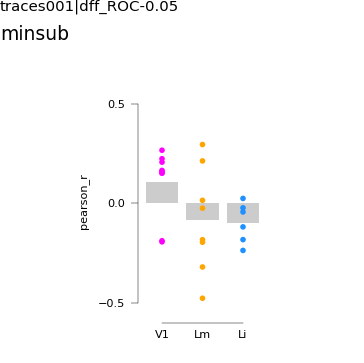

             count  mean   std   min   25%   50%   75%   max
visual_area                                                 
Li             6.0 -0.10  0.10 -0.24 -0.17 -0.08 -0.03  0.03
Lm             8.0 -0.08  0.26 -0.48 -0.23 -0.10  0.07  0.30
V1             9.0  0.11  0.17 -0.19  0.15  0.16  0.21  0.27
/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final tradeoff-pearsonr_offset-minsub_lum-exclude
      Contrast   A   B  Paired  Parametric  U-val       Tail  p-unc  p-corr  \
0  visual_area  Li  Lm   False       False   25.0  two-sided   0.95    0.95   
1  visual_area  Li  V1   False       False   10.0  two-sided   0.05    0.16   
2  visual_area  Lm  V1   False       False   22.0  two-sided   0.19    0.39   

  p-adjust  eta-square  
0     holm        0.00  
1     holm        0.32  
2     holm        0.16  


In [164]:
metric = 'pearson_r'
y_loc=0.4
fig, ax = pl.subplots(figsize=(3, 3), dpi=150)
ax, sts = pplot.stripplot_metric_by_area(tradeoff, metric, area_colors=area_colors,
                                markersize=3, ylim=(-1.04, 1.04), ax=ax,
                                posthoc='holm',
                                sig_fontsize=4, jitter=False, aspect=2,
                                plot_means=True, y_loc=y_loc, offset=y_loc/15.,
                                mean_type='mean', mean_style='bar', return_stats=True)
ax.set_yticks(np.linspace(-1, 1, 5))
print(tradeoff.groupby('visual_area')[metric].describe().round(2))
ax.set_ylim([-0.6, 0.62])
sns.despine(trim=True, ax=ax)
pplot.label_figure(fig, data_id)
fig.text(0, 0.9, offset_type)
figname = 'tradeoff-pearsonr_%s' % filter_str
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)
print(sts.round(2))

<IPython.core.display.Javascript object>


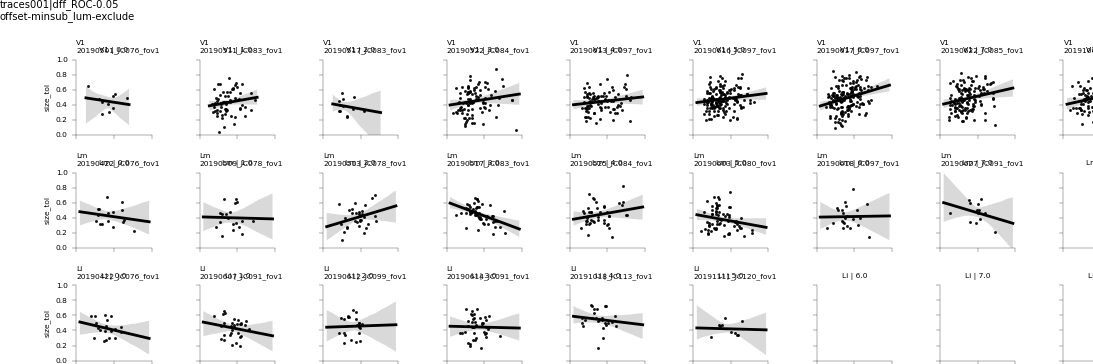

V1 0.0
V1 1.0
V1 2.0
V1 3.0
V1 4.0
V1 5.0
V1 6.0
V1 7.0
V1 8.0
Lm 0.0
Lm 1.0
Lm 2.0
Lm 3.0
Lm 4.0
Lm 5.0
Lm 6.0
Lm 7.0
Lm 8.0
Li 0.0
Li 1.0
Li 2.0
Li 3.0
Li 4.0
Li 5.0
Li 6.0
Li 7.0
Li 8.0
/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final tradeoff_eachfov_ offset-minsub_lum-exclude


In [165]:
fg = sns.FacetGrid(col='site_num', row='visual_area', row_order=visual_areas,
                   data=DF, height=1.5)
fg.map(sns.regplot, 'morph_sel', 'size_tol',
            truncate=False, color='k', scatter_kws={'s':2})
# DF["group"] = DF["site_num"].map(dict((k, v) for k, v in DF[['site_num', 'datakey']].values))

for ax in fg.axes.flat:
    ax.set_aspect('equal')
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 1])
pl.subplots_adjust(top=0.85)
    
[pl.setp(ax.texts, text="") for ax in fg.axes.flat] # remove the original texts
fg.set_titles(row_template='{row_name}', col_template='{col_name}')
axes = fg.axes.flatten()
for ax in axes:
    currt = ax.get_title()
    va = currt.split(' ')[0]
    snum = float(currt.split(' ')[2])
    print(va, snum)
    dk = DF[(DF.visual_area==va) & (DF['site_num']==snum)]['datakey'].unique()
    if len(dk)==0:
        continue
    new_t = '%s\n%s' % (va, dk[0])
    ax.set_title(new_t, fontsize=6, loc='left')
pl.subplots_adjust(left=0.05, right=0.95, hspace=0.5)
fg.fig.text(0.0, 0.95, filter_str, fontsize=8)

pplot.label_figure(fg.fig, data_id)
figname = 'tradeoff_eachfov_ %s' % filter_str 
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

<IPython.core.display.Javascript object>


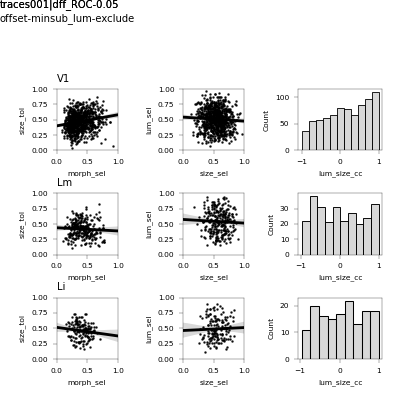

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final tradeoff_allcells_offset-minsub_lum-exclude


In [172]:
fig, axn = pl.subplots(3,3, figsize=(5,5))
for ax in axn[:, 0:-1].flat:
    ax.set_aspect('equal')
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 1])
for va, ixs_ in DF.dropna().groupby('visual_area'):
    vi = visual_areas.index(va)
    ax=axn[vi, 0]
    ax.set_title(va, loc='left')
    sns.regplot(x='morph_sel', y='size_tol', data=ixs_, ax=ax, 
                truncate=False, color='k', scatter_kws={'s':1})
    ax=axn[vi, 1]
    sns.regplot(x='size_sel', y='lum_sel', data=ixs_, ax=ax,
                truncate=False, color='k', scatter_kws={'s':1})
    ax=axn[vi, 2]
    sns.histplot(x='lum_size_cc', data=ixs_, ax=ax,
                color=[0.8]*3)

pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, top=0.8, wspace=0.5,
                  hspace=0.7)

fig.text(0.0, 0.95, filter_str, fontsize=8)

pplot.label_figure(fig, data_id)
figname = 'tradeoff_allcells_%s' % filter_str 
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

## Population sparseness

In [167]:
importlib.reload(sel)

<module 'analyze2p.objects.selectivity' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py'>

In [168]:
#x0 = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
remove_offset=False # Set false, offsets removed if neg. in calculatin index
NDATA = NDATA_all.copy() #if normalize_luminance else NDATA_im.copy()
pop_sparse = sel.aggregate_population_sparseness(NDATA, offset_type=offset_type,
                                                lcorrection=lcorrection, )
popdf = pop_sparse[(pop_sparse['population_sparseness']<=1.0) 
                 & (pop_sparse['population_sparseness']>=0)].copy()
print(pop_sparse.shape, popdf.shape)

(1150, 5) (1150, 5)


In [169]:
pDF = popdf[popdf['n_cells']>=min_ncells].copy().dropna()
print(pDF.shape)
pop_by_fov = pDF.groupby(['visual_area', 'datakey']).mean().reset_index()
pop_by_config = pDF.groupby(['visual_area', 'config']).mean().reset_index()

(1150, 5)


<IPython.core.display.Javascript object>


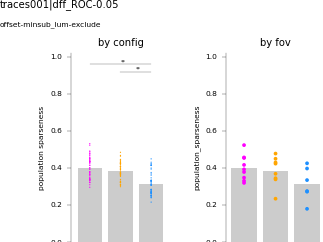

[mean]:
  visual_area  population_sparseness  population_sparseness_std
0          Li               0.313476                   0.060846
1          Lm               0.382850                   0.047450
2          V1               0.401640                   0.059633
[mean]:
  visual_area  population_sparseness  population_sparseness_std
0          Li               0.313476                   0.090592
1          Lm               0.382850                   0.078429
2          V1               0.401640                   0.067249
/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final population_sparseness_offset-minsub_lum-exclude


In [170]:
%matplotlib notebook
metric = 'population_sparseness'
multi_comp_test='fdr_bh' #'fdr_bh'

stat_cols = ['A', 'B', 'p-unc', 'p-corr', 'p-adjust', 'eta-square']
ylim = (0, 1.02)
y_loc = ylim[-1]-0.1

fig, axn = pl.subplots(1,2, figsize=(4,3))
for ai, ax in enumerate(axn.flat):
    plotdf = pop_by_config.dropna().copy() if ai==0 else pop_by_fov.copy()
    markersize = 1 if ai==0 else 3
    pplot.print_means(plotdf, groupby=['visual_area'], params=[metric], metric='mean')
    pplot.stripplot_metric_by_area(plotdf, metric=metric, ax=ax, mean_type='mean',
                            area_colors=area_colors, markersize=markersize,
                            y_loc=y_loc, sig_lw=0.2, offset=0.04, sig_fontsize=4,
                            ylim=ylim, aspect=2, mean_style='bar', jitter=False)
    ax.set_title('by config' if ai==0 else 'by fov')
fig.axes[0].set_ylabel('population sparseness')
pl.subplots_adjust(bottom=0.1, left=0.2, right=0.9, top=0.8, wspace=0.6)
fig.text(0.0, 0.9, filter_str, fontsize=6)

pplot.label_figure(fig, data_id)
figname = 'population_sparseness_%s' % filter_str
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [171]:
'20190603_JC080_fov1' in NDATA0['datakey'].unique()

True

In [353]:
import analyze2p.extraction.traces as traceutils

In [354]:
importlib.reload(traceutils)

<module 'analyze2p.extraction.traces' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/extraction/traces.py'>

In [355]:
dk = '20190506_JC080_fov1'
sdf = aggr.get_stimuli(dk, experiment='blobs')
soma_fpath = traceutils.get_data_fpath(dk, experiment_name='blobs',
                                       trace_type='np_subtracted')
raw_traces, labels, sdf, _ = traceutils.load_dataset(soma_fpath, 
                                    trace_type='corrected', add_offset=True, 
                                    create_new=True, save=False)

... processing data arrays, no save (corrected).
    adding raw offset (raw f0 offset: 551.30)
    adding raw offset (raw f0 offset: 93.05)


In [356]:
dff_traces, metrics = aggr.process_traces(raw_traces, labels, trace_type='dff',
                                        response_type='dff', 
                                        trial_epoch='stimulus')

--- processed traces: dff


In [357]:
metrics['visual_area'] = va
metrics['datakey'] = dk
metrics.loc[metrics.index, 'trial'] = metrics.index.tolist()

ndf = pd.melt(metrics, id_vars=['visual_area', 'datakey', 'config', 'trial'], var_name='cell', 
              value_name='response')

In [362]:
rdf0 = ndf.groupby(['visual_area', 'datakey', 'cell', 'config']).mean().reset_index()
print(rdf0['response'].min(), rdf0['response'].max())
rdf = sel.correct_offset(rdf0, offset='minsub')
print(rdf['response'].min(), rdf['response'].max())

-2.039759962278916 0.7086775120989621
0.0 2.3673981233120944


In [363]:
ixs_ = sel.calculate_metrics(rdf, sdf)

<IPython.core.display.Javascript object>


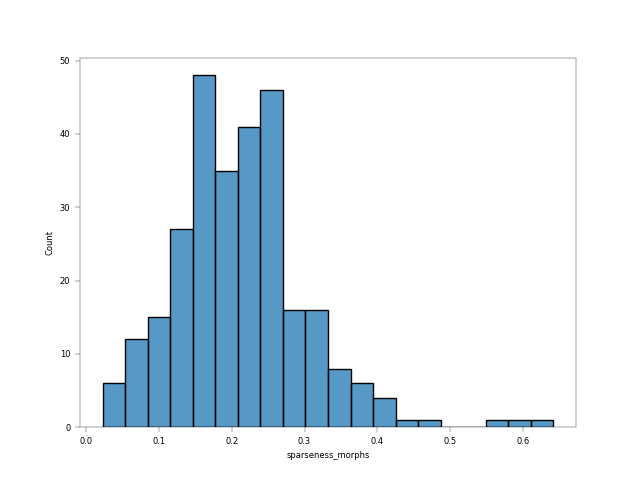

<AxesSubplot:xlabel='sparseness_morphs', ylabel='Count'>

In [364]:
# dk = '20190506_JC080_fov1'

fig, ax = pl.subplots()
sns.histplot(ixs_['sparseness_morphs'])


In [365]:
ixs_[ixs_['sparseness_morphs']==ixs_['sparseness_morphs'].max()]


,morph_sel,size_tol,sparseness_total,sparseness_morphs,sparseness_anchors,size_sel,lum_sel,lum_size_cc,lum_size_pval,cell
68,0.931275,0.074335,0.618336,0.641299,0.233219,0.925665,0.75703,-0.217338,0.72547,68


In [366]:
ixs_[ixs_['sparseness_morphs']==ixs_['sparseness_morphs'].min()]


,morph_sel,size_tol,sparseness_total,sparseness_morphs,sparseness_anchors,size_sel,lum_sel,lum_size_cc,lum_size_pval,cell
26,0.153983,0.971997,0.020868,0.023009,0.000205,0.028003,0.080561,-0.723343,0.167243,26


In [86]:
import analyze2p.correlations as cr

In [87]:
def do_pairwise_diffs_melt(df_, metric_name='morph_sel', include_diagonal=False):
    pairwise_diffs = pd.DataFrame(abs(df_[metric_name].values \
                                  - df_[metric_name].values[:, None]), 
                              columns=df_['cell'].values, index=df_['cell'].values)

    diffs = cr.melt_square_matrix(pairwise_diffs, metric_name=metric_name)
    diffs = diffs.rename(columns={'row': 'cell_1', 'col': 'cell_2'})
    diffs[['cell_1', 'cell_2']] = diffs[['cell_1', 'cell_2']].astype(int)
    diffs['neuron_pair'] = ['%i_%i' % (c1, c2) for \
                         c1, c2 in diffs[['cell_1', 'cell_2']].values]
    return diffs


In [88]:
DF['experiment'] = 'blobs'
DF = aggr.add_roi_positions(DF)

In [89]:
va = 'V1'
dk = '20191006_JC110_fov1'
df_ = DF[(DF.visual_area==va) & (DF.datakey==dk)]
df_.head()

,morph_sel,size_tol,sparseness_total,sparseness_morphs,sparseness_anchors,size_sel,lum_sel,lum_size_cc,lum_size_pval,cell,...,experiment,animalid,fov,session,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos
1337,0.592004,0.728200,0.175357,0.141727,0.212171,0.271800,0.774502,-0.051729,0.934167,4,...,blobs,JC110,FOV1_zoom2p0x,20191006,251.190607,109.0,51.400391,27.0,921.399609,926.409393
1338,0.113957,0.647360,0.129247,0.110111,0.063657,0.352640,0.224575,0.088116,0.887952,5,...,blobs,JC110,FOV1_zoom2p0x,20191006,235.059100,102.0,89.474755,47.0,883.325245,942.540900
1339,0.276746,0.485549,0.237714,0.209670,0.218234,0.514451,0.772925,0.617586,0.266994,11,...,blobs,JC110,FOV1_zoom2p0x,20191006,232.754599,101.0,72.341292,38.0,900.458708,944.845401
1340,0.399469,0.414261,0.229796,0.196078,0.232018,0.585739,0.550042,0.207764,0.737383,24,...,blobs,JC110,FOV1_zoom2p0x,20191006,163.619569,71.0,146.586301,77.0,826.213699,1013.980431
1341,0.431128,0.579382,0.233844,0.210213,0.202011,0.420618,0.522083,-0.489453,0.402673,33,...,blobs,JC110,FOV1_zoom2p0x,20191006,101.398043,44.0,211.312720,111.0,761.487280,1076.201957


In [120]:
d_=[]
for (va, dk), df_ in DF.groupby(['visual_area', 'datakey']):
    roi_pos = df_[['cell', 'ml_pos', 'ap_pos']].drop_duplicates().copy()
    d1 = do_pairwise_diffs_melt(df_, metric_name='morph_sel')
    d2 = do_pairwise_diffs_melt(df_, metric_name='lum_sel')
    d3 = do_pairwise_diffs_melt(df_, metric_name='size_tol')
    d4 = do_pairwise_diffs_melt(df_, metric_name='sparseness_morphs')
    
    diff_ = pd.merge(d1, d2).merge(d3).merge(d4)
    ddf_ = cr.get_pw_distance(diff_, roi_pos, )
    ddf_['visual_area'] = va
    ddf_['datakey'] = dk
    d_.append(ddf_)
diffdf = pd.concat(d_, axis=0, ignore_index=True)

In [121]:
fov_means = diffdf.groupby(['visual_area', 'datakey']).mean().reset_index()
fov_means.head()

,visual_area,datakey,cell_1,cell_2,morph_sel,lum_sel,size_tol,sparseness_morphs,cortical_distance
0,Li,20190422_JC076_fov1,212.228070,290.824561,0.138830,0.212143,0.140246,0.101740,300.508467
1,Li,20190602_JC091_fov1,73.975023,186.407956,0.176504,0.257779,0.165620,0.077016,241.740967
2,Li,20190609_JC099_fov1,175.890476,243.942857,0.175799,0.193444,0.147620,0.067895,298.747585
3,Li,20190614_JC091_fov1,154.052049,312.599114,0.138592,0.219539,0.153563,0.097312,304.634686
4,Li,20191018_JC113_fov1,80.583333,122.216667,0.150761,0.193619,0.139770,0.073069,255.527099


<IPython.core.display.Javascript object>


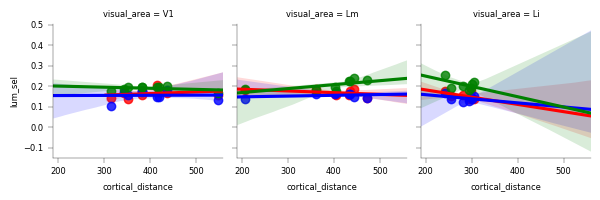

In [122]:
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=fov_means, 
                  height=2)
fg.map(sns.regplot, 'cortical_distance', 'morph_sel', truncate=False,
      color='r')
fg.map(sns.regplot, 'cortical_distance', 'size_tol', truncate=False,
      color='b')
fg.map(sns.regplot, 'cortical_distance', 'lum_sel', truncate=False,
      color='g')

In [132]:
# Binning params
n_bins=100
use_quartile=False
custom_bins=False
cmap='viridis'
qcolor_list = sns.color_palette(cmap, n_colors=n_bins)
# Bin data
to_quartile='cortical_distance'
bins, bin_labels, bin_colors = cr.get_bins(n_bins=n_bins, custom_bins=custom_bins)
bcorrs, bins_ = cr.bin_column_values(diffdf, to_quartile=to_quartile, 
                                     use_quartile=use_quartile, return_bins=True,
                                     n_bins=n_bins, bins=bins, labels=bin_labels)

<IPython.core.display.Javascript object>


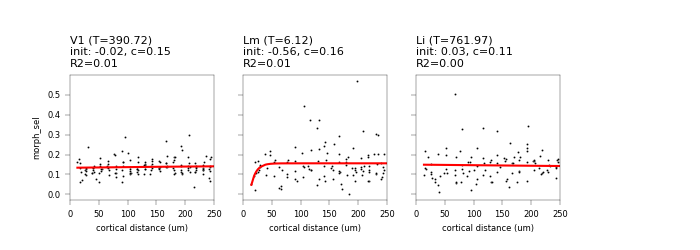

In [133]:
metric = 'morph_sel'
fit_sites=True
min_npairs = 3
n_iter=0
x_var = 'binned_%s' % to_quartile
cnt_grouper = [x_var, 'datakey'] if fit_sites else [x_var]

fig, axn = pl.subplots(1,3, figsize=(7,2.5), sharex=True, sharey=True)
for va, cc0 in bcorrs.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    pair_cnts = cc0.groupby(cnt_grouper)['neuron_pair'].count()  
    # How many resample per group
    nsamples_per = dict((k, v) for k, v \
                        in zip(pair_cnts[pair_cnts>min_npairs].index.tolist(),
                               pair_cnts[pair_cnts>min_npairs].values))
    # Sample
    cc_ = pd.concat([cg.sample(nsamples_per[c], random_state=n_iter, replace=True) \
                         for c, cg in cc0.groupby(cnt_grouper) \
                         if c in nsamples_per.keys()])
    # fov mean for visualizing
    fov_cc = cc_.groupby(cnt_grouper).median().reset_index().dropna()
    data = fov_cc.groupby(x_var).median()
    xd = data.sort_values(by=to_quartile)['cortical_distance'].values
    yd = data.sort_values(by=to_quartile)[metric].values
    #ax.plot(xd, yd, lw=0, color='k', marker='.')
    sns.scatterplot(x=to_quartile, y=metric, data=fov_cc, ax=ax,
                    s=2, color='k')
    res_, xvals, yvals = cr.fit_decay_on_binned(fov_cc, use_binned=False,
                                                normalize_x=True, func='halflife',
                                                estimator='median',
                                                metric=metric, #bin_column=bin_column,
                                                to_quartile=to_quartile,
                                                return_inputs=True)
    if all(res_.isnull()):
        print("BINNED, no fit: %s" % va)
        label='no fit'
    else:
        fit_y = cr.func_halflife(xvals, res_.init, res_.tau, res_.constant)
        ax.plot(xvals, fit_y, color='r')
        label = '%s (T=%.2f)\ninit: %.2f, c=%.2f\nR2=%.2f' \
                                % (va, res_.tau, res_.init, res_.constant, res_.R2)
    ax.set_title(label, loc='left')
    ax.set_xlabel('cortical distance (um)')
    ax.set_xlim([0, 250])
pl.subplots_adjust(bottom=0.2, left=0.1, right=0.8, top=0.7)


In [112]:
va, dk

('V1', '20191006_JC110_fov1')

<IPython.core.display.Javascript object>


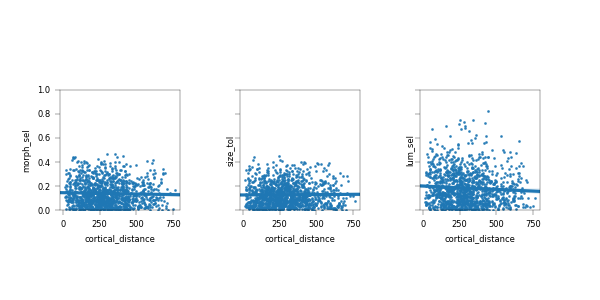

In [98]:
va='Li'
dk='20191105_JC117_fov1'
df_ = diffdf[(diffdf.visual_area==va) & (diffdf.datakey==dk)]

fig, axn = pl.subplots(1,3, figsize=(6, 3), sharex=True, sharey=True)
for ax, metric in zip(axn.flat, ['morph_sel', 'size_tol', 'lum_sel']):
    ax.set_ylim([0, 1])
    #ax.set_aspect('equal')
    sns.regplot(x='cortical_distance', y=metric, data=df_, ax=ax,
               truncate=False, scatter_kws={'s':1})
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8, wspace=0.5)

<IPython.core.display.Javascript object>


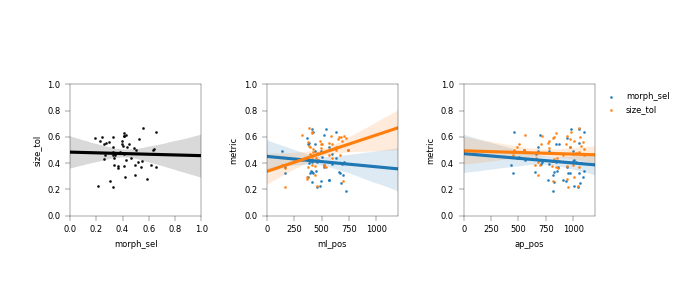

In [99]:
df_ = DF[(DF.visual_area==va) & (DF.datakey==dk)]
fig, axn = pl.subplots(1, 3, figsize=(7, 3), sharex=False, sharey=False)
ax=axn[0]
ax.set_ylim([0, 1])
ax.set_xlim([0, 1])
ax.set_aspect('equal')
sns.regplot(x='morph_sel', y='size_tol', ax=ax, data=df_,
           truncate=False, color='k', scatter_kws={'s':1})

for ax, axis in zip(axn.flat[1:], ['ml_pos', 'ap_pos']):
    ax.set_ylim([0,1])
    ax.set_xlim([0, 1200])
    sns.regplot(x=axis, y='morph_sel', ax=ax, data=df_, label='morph_sel',
               truncate=False, scatter_kws={'s':1})
    sns.regplot(x=axis, y='size_tol', ax=ax, data=df_, label='size_tol',
               truncate=False, scatter_kws={'s':1})
    ax.set_ylabel('metric')
    #ax.set_aspect(0.1)
    #force_aspect(ax,aspect=1)
    ax.set_box_aspect(1)
ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, top=0.8, wspace=0.5)

In [100]:
def get_best_x(rd):
    '''
    Get best morph and best size (rd=ndf[ndf.cell==x])
    '''
    sizr = sel.get_x_curves_at_best_y(rd[rd.morphlevel!=-1], 
                              x='size', y='morphlevel', normalize=False)
    best_mp = int(sizr['morphlevel'].unique())

    morphr = sel.get_x_curves_at_best_y(rd[rd.morphlevel!=-1], 
                              x='morphlevel', y='size', normalize=False)
    best_sz = int(morphr['size'].unique())

    return pd.Series({'morphlevel': best_mp, 'size': best_sz})



In [101]:
for (va, dk), df_ in DF.groupby(['visual_area', 'datakey']):
    ndf = pd.concat([NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk) 
              & (NDATA.cell.isin(g['cell'].unique()))] \
                for (va, dk), g in df_.groupby(['visual_area', 'datakey'])]).copy()
    ndf['size'] = sdf.loc[ndf['config'].values]['size'].values
    ndf['morphlevel'] = sdf.loc[ndf['config'].values]['morphlevel'].values
    bestvs = ndf.groupby('cell').apply(get_best_x)
    df_['best_morphlevel'] = bestvs.loc[df_['cell'].values]['morphlevel'].values
    df_['best_size'] = bestvs.loc[df_['cell'].values]['size'].values
    DF.loc[df_.index, 'best_morphlevel'] = df_['best_morphlevel']
    DF.loc[df_.index, 'best_size'] = df_['best_size']

<IPython.core.display.Javascript object>


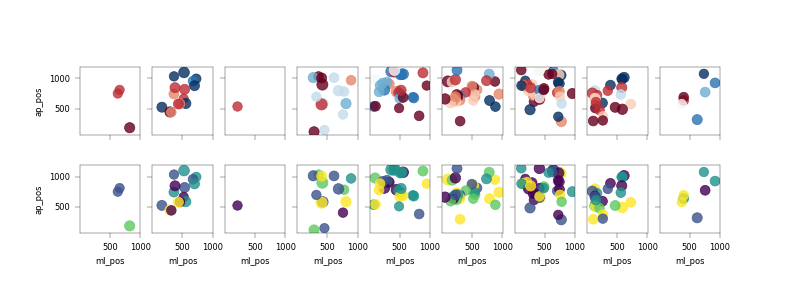

<IPython.core.display.Javascript object>


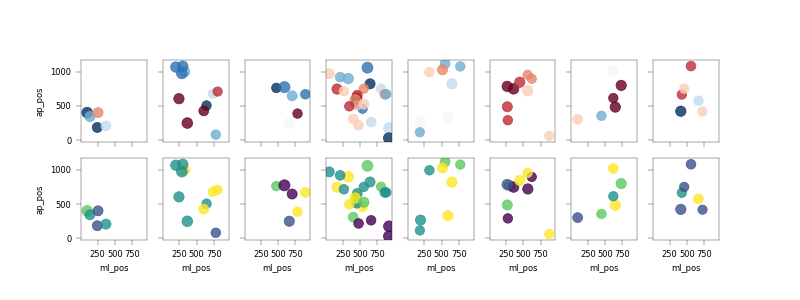

<IPython.core.display.Javascript object>


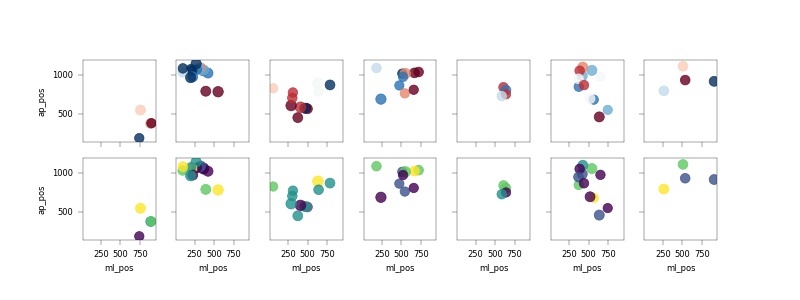

In [149]:
for va in visual_areas:
    plotd = DF[(DF.visual_area==va) & (DF['morph_sel']>=0.5)].copy()

    n_fovs = len(plotd['datakey'].unique())
    fig, axn = pl.subplots(2, n_fovs, figsize=(8, 3), sharex=True, sharey=True)
    size_value='morph_sel'

    for di, (dk, df_) in enumerate(plotd.groupby(['datakey'])):

        for hi, hue_name in enumerate(['best_morphlevel', 'best_size']):
            ax = axn[hi, di]
            metric_cmap = 'RdBu' if hue_name=='best_morphlevel' else 'viridis'
            hue_norm = (0, 106) if hue_name=='best_morphlevel' else (10, 50) 
            sns.scatterplot(x='ml_pos', y='ap_pos', data=df_, ax=ax, 
                        size=size_value, size_norm=(0, 1), palette=metric_cmap,
                        hue=hue_name, hue_norm=hue_norm, marker='o',
                        edgecolor=None, alpha=0.8, legend=False)
            ax.set_aspect('equal')
    pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

<IPython.core.display.Javascript object>


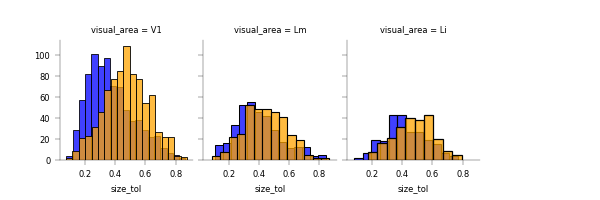

In [150]:
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=DF,
                  height=2)
fg.map(sns.histplot, 'morph_sel', color='blue')
fg.map(sns.histplot, 'size_tol', color='orange')

pl.subplots_adjust(left=0.1, bottom=0.2, top=0.8, right=0.8)

<IPython.core.display.Javascript object>


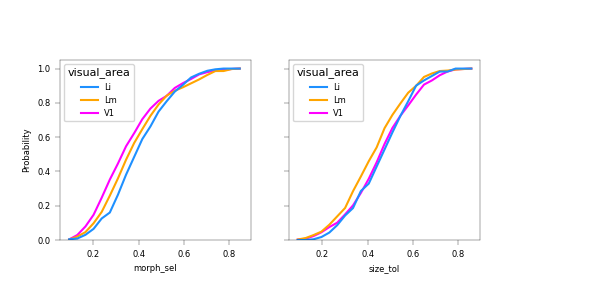

In [108]:
fig, axn=pl.subplots(1,2, figsize=(6,3), sharex=True, sharey=True)
sns.histplot(x='morph_sel', hue='visual_area', data=DF, ax=axn[0],
            palette=area_colors, stat='probability', fill=False,
            cumulative=True, common_norm=False, element='poly')
sns.histplot(x='size_tol', hue='visual_area', data=DF, ax=axn[1],
            palette=area_colors, stat='probability',fill=False,
            cumulative=True, common_norm=False, element='poly')
pl.subplots_adjust(left=0.1, bottom=0.2, top=0.8, right=0.8)

In [179]:
d_=[]
for (va, dk), df_ in DF.groupby(['visual_area', 'datakey']):
    roi_pos = df_[['cell', 'ml_pos', 'ap_pos']].drop_duplicates().copy()
    d1 = do_pairwise_diffs_melt(df_, metric_name='best_morphlevel')
    d2 = do_pairwise_diffs_melt(df_, metric_name='best_size')
    diff_ = pd.merge(d1, d2)
    ddf_ = cr.get_pw_distance(diff_, roi_pos)
    ddf_['visual_area'] = va
    ddf_['datakey'] = dk
    d_.append(ddf_)
bestdiffs = pd.concat(d_, axis=0, ignore_index=True)

In [185]:
# ------------------------------
cmap='viridis'
custom_bins=False
# ------------------------------
n_iterations=500
n_samples=None
# ------------------------------
# Get bins
to_quartile='cortical_distance'
n_bins=100
use_quartile=False
bins, bin_labels, bin_colors = cr.get_bins(n_bins=n_bins, custom_bins=custom_bins, 
                                            cmap=cmap)
# Bin ---------------------------------------------------
bcorrs, bins_ = cr.bin_column_values(bestdiffs, to_quartile=to_quartile, 
                     use_quartile=use_quartile, return_bins=True,
                     n_bins=n_bins, bins=bins, labels=bin_labels)
bcorrs = bcorrs.dropna()
# Add bin value to df
bin_values = bcorrs.groupby(['binned_%s' % to_quartile])[to_quartile].median()
bin_lut = dict((k, v) for k, v in zip(bin_labels, bin_values))
bcorrs['bin_value'] = [bin_lut[b] for b in bcorrs['binned_%s' % to_quartile]]


<IPython.core.display.Javascript object>


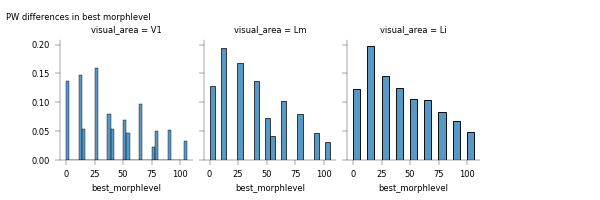

Text(0.01, 0.9, 'PW differences in best morphlevel')

In [186]:
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, height=2, data=bestdiffs)
fg.map(sns.histplot, 'best_morphlevel', stat='probability', common_norm=False)
pl.subplots_adjust(left=0.1, bottom=0.2, top=0.8, right=0.8)

fg.fig.text(0.01, 0.9, 'PW differences in best morphlevel')

<IPython.core.display.Javascript object>


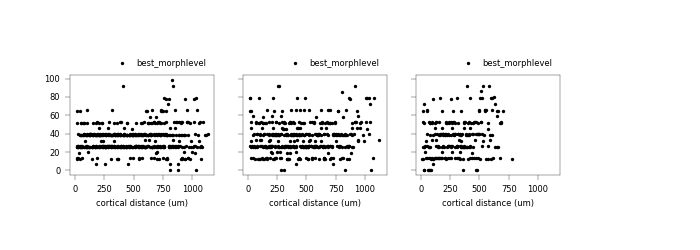

    val out of bounds
BINNED, no fit: Li
    val out of bounds
BINNED, no fit: Lm
    val out of bounds
BINNED, no fit: V1


In [187]:
n_iter=int(np.random.rand(1)[0]*500)
min_npairs = 3
x_var = 'binned_%s' % to_quartile
metric = 'best_morphlevel'
fit_sites = True
xlabel='cortical distance (um)' if to_quartile=='cortical_distance' \
            else 'RF distance (deg)'
cnt_grouper = [x_var] 
if fit_sites:
    cnt_grouper.append('datakey')
    
fig, axn = pl.subplots(1,3, figsize=(7,2.5), sharex=True, sharey=True)
for va, cc0 in bcorrs.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    cnts = cc0.groupby(cnt_grouper)['neuron_pair'].count()  
    # How many resample per group
    nsamples_per = dict((k, v) for k, v \
                        in zip(cnts[cnts>min_npairs].index.tolist(),
                               cnts[cnts>min_npairs].values))
    # Sample
    cc_ = pd.concat([cg.sample(nsamples_per[c], random_state=n_iter, replace=True) \
                         for c, cg in cc0.groupby(cnt_grouper) \
                         if c in nsamples_per.keys()])
    # fov mean for visualizing
    fov_cc = cc_.groupby(cnt_grouper).median().reset_index().dropna()
    # plot
    ax.scatter(x=to_quartile, y=metric, data=fov_cc, 
                s=2, color='k')
    res_, xvals, yvals = cr.fit_decay_on_binned(fov_cc, use_binned=False,
                                            normalize_x=True, func='halflife',
                                            estimator='median',
                                            metric=metric,
                                            to_quartile=to_quartile,
                                            return_inputs=True)
    if all(res_.isnull()):
        print("BINNED, no fit: %s" % va)
        label='no fit'
    else:
        fit_y = cr.func_halflife(xvals, res_.init, res_.tau, res_.constant)
        label = '%s (T=%.2f)\ninit: %.1f, c=%.2f\nR2=%.2f' \
                        % (va, res_.tau, res_.init, res_.constant, res_.R2)
        ax.plot(xvals, fit_y, color='r', label=label)
    #ax.set_ylim([-0.2, 0.6])
    #ax.set_title(label, loc='left')
    ax.set_xlabel(xlabel)
    ax.legend(bbox_to_anchor=(1,1), loc='lower right', frameon=False, ncol=2)
       #ax.set_title(va)
pl.subplots_adjust(bottom=0.3, left=0.1, right=0.8, top=0.7)

In [188]:
min_ncells=20
final_counts = DF[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count().reset_index()
curr_ds = final_counts[ (final_counts['cell']>=min_ncells)]

In [189]:
max_nfovs = curr_ds['visual_area'].value_counts().max()
max_nfovs

8

<IPython.core.display.Javascript object>


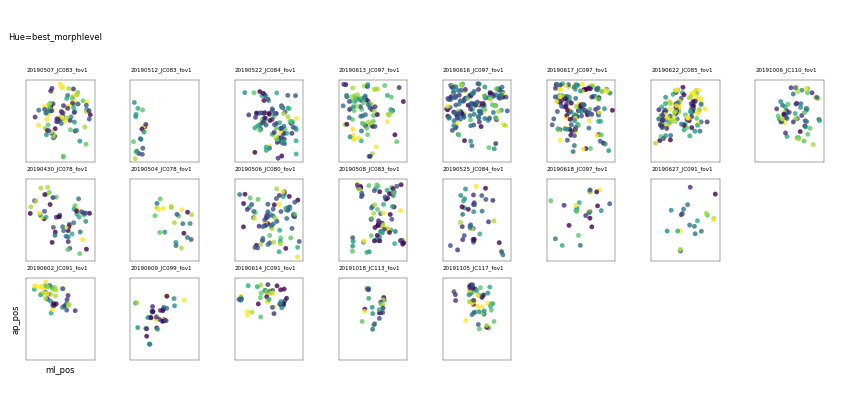

Text(0.01, 0.9, 'Hue=best_morphlevel')

In [192]:
metric = 'best_morphlevel'
cmap='viridis'
fig, axn = pl.subplots(3, max_nfovs, sharex=True, sharey=True, figsize=(8.5,4))
for va, curr_ in curr_ds.groupby('visual_area'):
    vi = visual_areas.index(va)
    for ai, (va, dk, nc) in enumerate(curr_.values):
        ax=axn[vi, ai]
        ax.set_title(dk, fontsize=4, loc='left')
        df_ = DF[(DF.visual_area==va) & (DF.datakey==dk)]

        sns.scatterplot(x='ml_pos', y='ap_pos', data=df_, ax=ax,
                        hue=metric, palette=cmap, s=10, 
                        edgecolor=None, alpha=0.8, legend=False)
        ax.set_aspect('equal')
        #ax.legend_.remove()
        ax.tick_params(which='both', axis='both', size=0)
        ax.set_xticks([])
        ax.set_yticks([])
    for ax in axn[vi, ai+1:].flat:
        ax.axis('off')
pl.subplots_adjust(left=0.02, right=0.98, bottom=0.1, top=0.8)
fig.text(0.01, 0.9, 'Hue=%s' % metric)

<IPython.core.display.Javascript object>


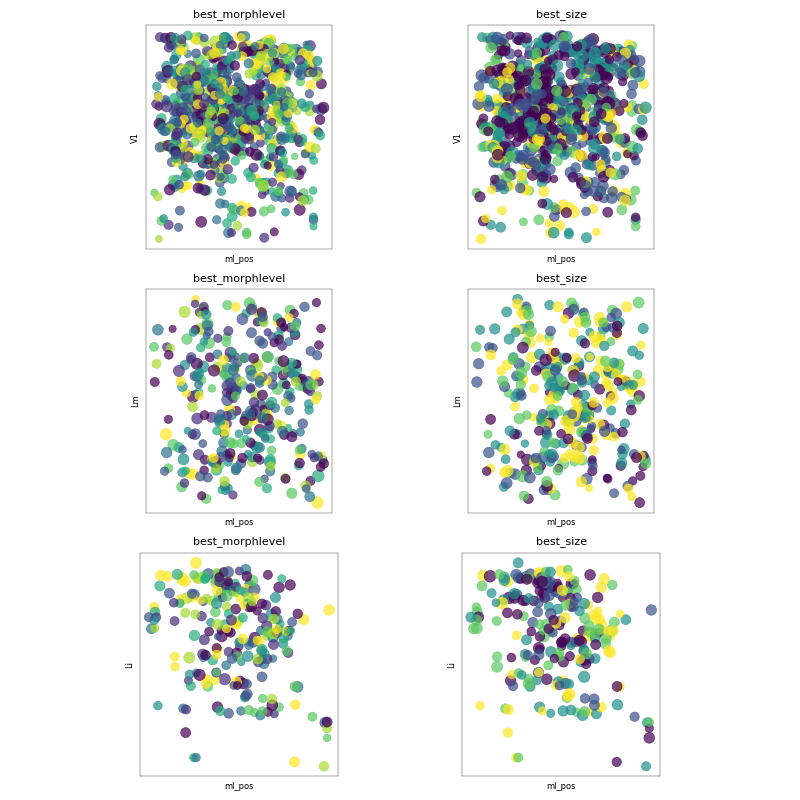

In [193]:

metric_list = ['morph_sel', 'size_tol', 'lum_sel']
metric_list = ['best_morphlevel', 'best_size']

fig, axn = pl.subplots(3,len(metric_list), figsize=(8,8))

for va, df_ in DF.groupby('visual_area'):
    vi = visual_areas.index(va)
    for ai, metric in enumerate(metric_list):
        ax=axn[vi, ai]
        size_value = 'size_tol' if 'size' in metric else 'morph_sel'
        sns.scatterplot(x='ml_pos', y='ap_pos', data=df_, ax=ax,
                        hue=metric, palette=cmap, size=size_value,
                        size_norm=(0, 0.8),
                        edgecolor=None, alpha=0.7, legend=False,
                        vmin=0, vmax=1)
        ax.set_aspect('equal')
        #ax.legend_.remove()
        ax.tick_params(which='both', axis='both', size=0)
        ax.set_title(metric)
        ax.set_ylabel(va)
        ax.set_xticks([])
        ax.set_yticks([])
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.3, top=0.8, wspace=0.2, hspace=0.4)
pl.tight_layout()